In [1]:
!pip install geopy folium lightgbm langchain langchain-community chromadb sentence-transformers prophet



# Importation

In [2]:
import requests
import time
import folium
import joblib

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lightgbm import LGBMRegressor
from prophet import Prophet
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from folium.plugins import HeatMap

# Préparation des données

In [3]:
data = pd.read_csv("/content/drive/MyDrive/all_data.csv")
data

Order ID                     Product Quantity Ordered Price Each  \
0        176558        USB-C Charging Cable                2      11.95   
1           NaN                         NaN              NaN        NaN   
2        176559  Bose SoundSport Headphones                1      99.99   
3        176560                Google Phone                1        600   
4        176560            Wired Headphones                1      11.99   
...         ...                         ...              ...        ...   
186845   259353      AAA Batteries (4-pack)                3       2.99   
186846   259354                      iPhone                1        700   
186847   259355                      iPhone                1        700   
186848   259356      34in Ultrawide Monitor                1     379.99   
186849   259357        USB-C Charging Cable                1      11.95   

            Order Date                         Purchase Address  
0       04/19/19 08:46             917 1st St, Dallas, TX 75001  
1                  NaN                                      NaN  
2       04/07/19 22:30        682 Chestnut St, Boston, MA 02215  
3       04/12/19 14:38     669 Spruce St, Los Angeles, CA 90001  
4       04/12/19 14:38     669 Spruce St, Los Angeles, CA 90001  
...                ...                                      ...  
186845  09/17/19 20:56   840 Highland St, Los Angeles, CA 90001  
186846  09/01/19 16:00  216 Dogwood St, San Francisco, CA 94016  
186847  09/23/19 07:39     220 12th St, San Francisco, CA 94016  
186848  09/19/19 17:30   511 Forest St, San Francisco, CA 94016  
186849  09/30/19 00:18   250 Meadow St, San Francisco, CA 94016  

[186850 rows x 6 columns]

Ajout de la colonne **geographic zone** sous la forme **Ville** (**état**) à partir de la colonne **Purchase Address**

In [4]:
data["Geographic Zone"] = (data["Purchase Address"].str.split(", ").str[-2]+" (" +data["Purchase Address"].str.split(" ").str[-2] + ")")
data[["Purchase Address","Geographic Zone"]]

Purchase Address     Geographic Zone
0                  917 1st St, Dallas, TX 75001         Dallas (TX)
1                                           NaN                 NaN
2             682 Chestnut St, Boston, MA 02215         Boston (MA)
3          669 Spruce St, Los Angeles, CA 90001    Los Angeles (CA)
4          669 Spruce St, Los Angeles, CA 90001    Los Angeles (CA)
...                                         ...                 ...
186845   840 Highland St, Los Angeles, CA 90001    Los Angeles (CA)
186846  216 Dogwood St, San Francisco, CA 94016  San Francisco (CA)
186847     220 12th St, San Francisco, CA 94016  San Francisco (CA)
186848   511 Forest St, San Francisco, CA 94016  San Francisco (CA)
186849   250 Meadow St, San Francisco, CA 94016  San Francisco (CA)

[186850 rows x 2 columns]

In [5]:
data["Geographic Zone"].unique()

array(['Dallas (TX)', nan, 'Boston (MA)', 'Los Angeles (CA)',
       'San Francisco (CA)', 'Seattle (WA)', 'Atlanta (GA)',
       'New York City (NY)', 'Portland (OR)', 'Austin (TX)',
       'Portland (ME)'], dtype=object)

On remarque notamment la présence de "nan", cela suggère la présence de ligne vide dans nos données. On devra les nettoyer

In [6]:
clean_data = data[~data["Geographic Zone"].isna()]
clean_data

Order ID                     Product Quantity Ordered Price Each  \
0        176558        USB-C Charging Cable                2      11.95   
2        176559  Bose SoundSport Headphones                1      99.99   
3        176560                Google Phone                1        600   
4        176560            Wired Headphones                1      11.99   
5        176561            Wired Headphones                1      11.99   
...         ...                         ...              ...        ...   
186845   259353      AAA Batteries (4-pack)                3       2.99   
186846   259354                      iPhone                1        700   
186847   259355                      iPhone                1        700   
186848   259356      34in Ultrawide Monitor                1     379.99   
186849   259357        USB-C Charging Cable                1      11.95   

            Order Date                         Purchase Address  \
0       04/19/19 08:46             917 1st St, Dallas, TX 75001   
2       04/07/19 22:30        682 Chestnut St, Boston, MA 02215   
3       04/12/19 14:38     669 Spruce St, Los Angeles, CA 90001   
4       04/12/19 14:38     669 Spruce St, Los Angeles, CA 90001   
5       04/30/19 09:27        333 8th St, Los Angeles, CA 90001   
...                ...                                      ...   
186845  09/17/19 20:56   840 Highland St, Los Angeles, CA 90001   
186846  09/01/19 16:00  216 Dogwood St, San Francisco, CA 94016   
186847  09/23/19 07:39     220 12th St, San Francisco, CA 94016   
186848  09/19/19 17:30   511 Forest St, San Francisco, CA 94016   
186849  09/30/19 00:18   250 Meadow St, San Francisco, CA 94016   

           Geographic Zone  
0              Dallas (TX)  
2              Boston (MA)  
3         Los Angeles (CA)  
4         Los Angeles (CA)  
5         Los Angeles (CA)  
...                    ...  
186845    Los Angeles (CA)  
186846  San Francisco (CA)  
186847  San Francisco (CA)  
186848  San Francisco (CA)  
186849  San Francisco (CA)  

[185950 rows x 7 columns]

Les Données qui nous intéressent sont ceux concernant la vente de "ThinkPad Laptop" et de "AAA Batteries (4-pack)"

In [7]:
target_data = clean_data[clean_data["Product"].isin(("ThinkPad Laptop","AAA Batteries (4-pack)"))]

# Analyse de données

## Analyse Géographique

Calculons la demande par zone géographique

In [8]:
target_data["Quantity Ordered"] = target_data["Quantity Ordered"].astype(int)
demand_by_zone = target_data.groupby("Geographic Zone")["Quantity Ordered"].sum().reset_index()
demand_by_zone

/tmp/ipython-input-2889706763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data["Quantity Ordered"] = target_data["Quantity Ordered"].astype(int)


Geographic Zone  Quantity Ordered
0        Atlanta (GA)              2716
1         Austin (TX)              1878
2         Boston (MA)              3908
3         Dallas (TX)              2849
4    Los Angeles (CA)              5608
5  New York City (NY)              4684
6       Portland (ME)               411
7       Portland (OR)              1943
8  San Francisco (CA)              8371
9        Seattle (WA)              2779

Nos données ne contenant pas la latitude et la longitude de ces zones géographiques, nous allons les récupérer avec l'API de OpenStreet Map cela pour pouvoir faire une visualisation sur une carte intéractive

In [9]:
def get_coordinates(city_state):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": city_state,
        "format": "json",
        "limit": 1
    }
    response = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    data = response.json()

    if len(data) > 0:
        return float(data[0]["lat"]), float(data[0]["lon"])
    else:
        return None, None

coordinates = {}

for zone in demand_by_zone["Geographic Zone"].unique():
    lat, lon = get_coordinates(zone)
    print(zone, lat, lon)
    coordinates[zone] = (lat, lon)
    time.sleep(1)

demand_by_zone["Latitude"] = demand_by_zone["Geographic Zone"].apply(lambda x: coordinates[x][0])
demand_by_zone["Longitude"] = demand_by_zone["Geographic Zone"].apply(lambda x: coordinates[x][1])

Atlanta (GA) 33.7544657 -84.3898151
Austin (TX) 30.2711286 -97.7436995
Boston (MA) 42.3554334 -71.060511
Dallas (TX) 32.7762719 -96.7968559
Los Angeles (CA) 34.0536909 -118.242766
New York City (NY) 40.7127281 -74.0060152
Portland (ME) 43.6634708 -70.2584907
Portland (OR) 45.5202471 -122.674194
San Francisco (CA) 37.7792588 -122.4193286
Seattle (WA) 47.6038321 -122.330062


In [10]:
demand_by_zone

Geographic Zone  Quantity Ordered   Latitude   Longitude
0        Atlanta (GA)              2716  33.754466  -84.389815
1         Austin (TX)              1878  30.271129  -97.743700
2         Boston (MA)              3908  42.355433  -71.060511
3         Dallas (TX)              2849  32.776272  -96.796856
4    Los Angeles (CA)              5608  34.053691 -118.242766
5  New York City (NY)              4684  40.712728  -74.006015
6       Portland (ME)               411  43.663471  -70.258491
7       Portland (OR)              1943  45.520247 -122.674194
8  San Francisco (CA)              8371  37.779259 -122.419329
9        Seattle (WA)              2779  47.603832 -122.330062

In [11]:
map_center = [39.8283, -98.5795]
map = folium.Map(location=map_center, zoom_start=4)

heat_data = [
    [row["Latitude"], row["Longitude"], row["Quantity Ordered"]]
    for i,row in demand_by_zone.iterrows()
]
HeatMap(heat_data, max_zoom=10, radius=30).add_to(map)
display(map)


## Analyse Temporelle

Passons maintenant à l'analyse temporelle de nos données. Comme nous disposons de la colonne "Order Date", on peut analyser les tendances par saison et par régions

In [12]:
target_data["Order Date"] = target_data["Order Date"].astype("datetime64[ns]")
target_data

/tmp/ipython-input-967123401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data["Order Date"] = target_data["Order Date"].astype("datetime64[ns]")


Order ID                 Product  Quantity Ordered Price Each  \
20       176575  AAA Batteries (4-pack)                 1       2.99   
28       176583  AAA Batteries (4-pack)                 2       2.99   
32       176586  AAA Batteries (4-pack)                 2       2.99   
45       176598  AAA Batteries (4-pack)                 2       2.99   
54       176607  AAA Batteries (4-pack)                 2       2.99   
...         ...                     ...               ...        ...   
186829   259338  AAA Batteries (4-pack)                 2       2.99   
186835   259344  AAA Batteries (4-pack)                 2       2.99   
186836   259345         ThinkPad Laptop                 1     999.99   
186840   259349  AAA Batteries (4-pack)                 1       2.99   
186845   259353  AAA Batteries (4-pack)                 3       2.99   

                Order Date                         Purchase Address  \
20     2019-04-27 00:30:00     433 Hill St, New York City, NY 10001   
28     2019-04-20 12:00:00       146 Jackson St, Portland, OR 97035   
32     2019-04-10 17:00:00   365 Center St, San Francisco, CA 94016   
45     2019-04-21 20:33:00     294 Park St, San Francisco, CA 94016   
54     2019-04-18 12:11:00            689 10th St, Boston, MA 02215   
...                    ...                                      ...   
186829 2019-09-02 21:29:00        666 Lakeview St, Boston, MA 02215   
186835 2019-09-10 23:33:00  721 Madison St, San Francisco, CA 94016   
186836 2019-09-21 23:12:00  406 Dogwood St, San Francisco, CA 94016   
186840 2019-09-01 22:14:00           911 River St, Dallas, TX 75001   
186845 2019-09-17 20:56:00   840 Highland St, Los Angeles, CA 90001   

           Geographic Zone  
20      New York City (NY)  
28           Portland (OR)  
32      San Francisco (CA)  
45      San Francisco (CA)  
54             Boston (MA)  
...                    ...  
186829         Boston (MA)  
186835  San Francisco (CA)  
186836  San Francisco (CA)  
186840         Dallas (TX)  
186845    Los Angeles (CA)  

[24769 rows x 7 columns]

In [13]:
target_data["Order Date"] = target_data["Order Date"].astype("datetime64[ns]")
target_data = target_data.dropna(subset=["Order Date"])

target_data["Year"] = target_data["Order Date"].dt.year
target_data["Month"] = target_data["Order Date"].dt.month
target_data["Day"] = target_data["Order Date"].dt.day
target_data["Hour"] = target_data["Order Date"].dt.hour
target_data["Month_Name"] = target_data["Order Date"].dt.strftime("%B")

def get_season(month):
    if month in [12, 1, 2]:
        return "Hiver"
    elif month in [3, 4, 5]:
        return "Printemps"
    elif month in [6, 7, 8]:
        return "Eté"
    else:
        return "Automne"

target_data["Season"] = target_data["Month"].apply(get_season)


/tmp/ipython-input-2850053072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data["Order Date"] = target_data["Order Date"].astype("datetime64[ns]")


Voyons d'abord la distribution des données selon les années

In [14]:
target_data["Year"].value_counts()

Year
2019    24764
2020        5
Name: count, dtype: int64

Nous avons majoritairement des données pour l'année 2019

In [15]:
target_data[target_data["Year"]==2020]

Order ID                 Product  Quantity Ordered Price Each  \
39308   304165  AAA Batteries (4-pack)                 1       2.99   
41914   306655         ThinkPad Laptop                 1     999.99   
42207   306928         ThinkPad Laptop                 1     999.99   
50158   314552  AAA Batteries (4-pack)                 1       2.99   
50774   315138  AAA Batteries (4-pack)                 3       2.99   

               Order Date                       Purchase Address  \
39308 2020-01-01 04:13:00       825 Adams St, Portland, OR 97035   
41914 2020-01-01 01:46:00  431 Hickory St, Los Angeles, CA 90001   
42207 2020-01-01 03:14:00           762 Elm St, Boston, MA 02215   
50158 2020-01-01 01:47:00    541 4th St, San Francisco, CA 94016   
50774 2020-01-01 00:51:00  257 Adams St, New York City, NY 10001   

          Geographic Zone  Year  Month  Day  Hour Month_Name Season  
39308       Portland (OR)  2020      1    1     4    January  Hiver  
41914    Los Angeles (CA)  2020      1    1     1    January  Hiver  
42207         Boston (MA)  2020      1    1     3    January  Hiver  
50158  San Francisco (CA)  2020      1    1     1    January  Hiver  
50774  New York City (NY)  2020      1    1     0    January  Hiver

Ces 5 données ne constituant pas une tendance exploitable, nous  allons les nettoyer pour la suite

In [16]:
target_data = target_data[target_data["Year"]==2019]
target_data

Order ID                 Product  Quantity Ordered Price Each  \
20       176575  AAA Batteries (4-pack)                 1       2.99   
28       176583  AAA Batteries (4-pack)                 2       2.99   
32       176586  AAA Batteries (4-pack)                 2       2.99   
45       176598  AAA Batteries (4-pack)                 2       2.99   
54       176607  AAA Batteries (4-pack)                 2       2.99   
...         ...                     ...               ...        ...   
186829   259338  AAA Batteries (4-pack)                 2       2.99   
186835   259344  AAA Batteries (4-pack)                 2       2.99   
186836   259345         ThinkPad Laptop                 1     999.99   
186840   259349  AAA Batteries (4-pack)                 1       2.99   
186845   259353  AAA Batteries (4-pack)                 3       2.99   

                Order Date                         Purchase Address  \
20     2019-04-27 00:30:00     433 Hill St, New York City, NY 10001   
28     2019-04-20 12:00:00       146 Jackson St, Portland, OR 97035   
32     2019-04-10 17:00:00   365 Center St, San Francisco, CA 94016   
45     2019-04-21 20:33:00     294 Park St, San Francisco, CA 94016   
54     2019-04-18 12:11:00            689 10th St, Boston, MA 02215   
...                    ...                                      ...   
186829 2019-09-02 21:29:00        666 Lakeview St, Boston, MA 02215   
186835 2019-09-10 23:33:00  721 Madison St, San Francisco, CA 94016   
186836 2019-09-21 23:12:00  406 Dogwood St, San Francisco, CA 94016   
186840 2019-09-01 22:14:00           911 River St, Dallas, TX 75001   
186845 2019-09-17 20:56:00   840 Highland St, Los Angeles, CA 90001   

           Geographic Zone  Year  Month  Day  Hour Month_Name     Season  
20      New York City (NY)  2019      4   27     0      April  Printemps  
28           Portland (OR)  2019      4   20    12      April  Printemps  
32      San Francisco (CA)  2019      4   10    17      April  Printemps  
45      San Francisco (CA)  2019      4   21    20      April  Printemps  
54             Boston (MA)  2019      4   18    12      April  Printemps  
...                    ...   ...    ...  ...   ...        ...        ...  
186829         Boston (MA)  2019      9    2    21  September    Automne  
186835  San Francisco (CA)  2019      9   10    23  September    Automne  
186836  San Francisco (CA)  2019      9   21    23  September    Automne  
186840         Dallas (TX)  2019      9    1    22  September    Automne  
186845    Los Angeles (CA)  2019      9   17    20  September    Automne  

[24764 rows x 13 columns]

Pour la suite, pour plus de clarté dans nos plots, nous allons les séparer en plusieurs plots par ville.

### Tendances horaire

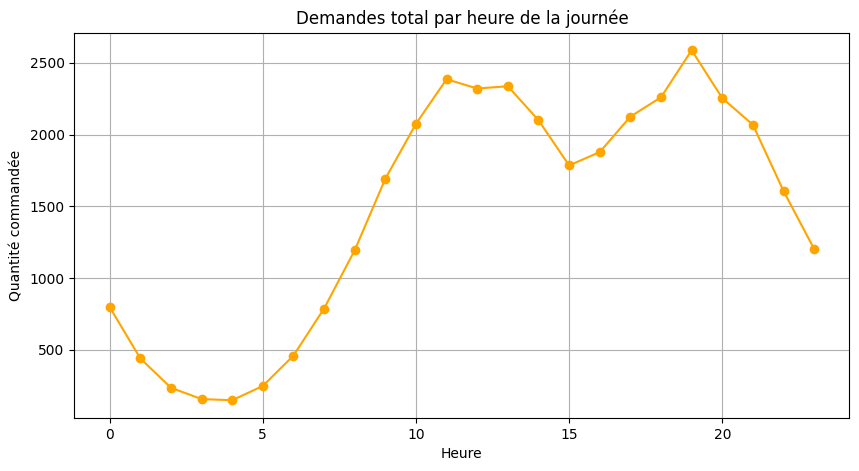

In [17]:
hourly_demand = target_data.groupby("Hour")["Quantity Ordered"].sum()

plt.figure(figsize=(10,5))
hourly_demand.plot(kind="line", marker="o", color="orange")
plt.title("Demandes total par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Quantité commandée")
plt.grid(True)

plt.show()

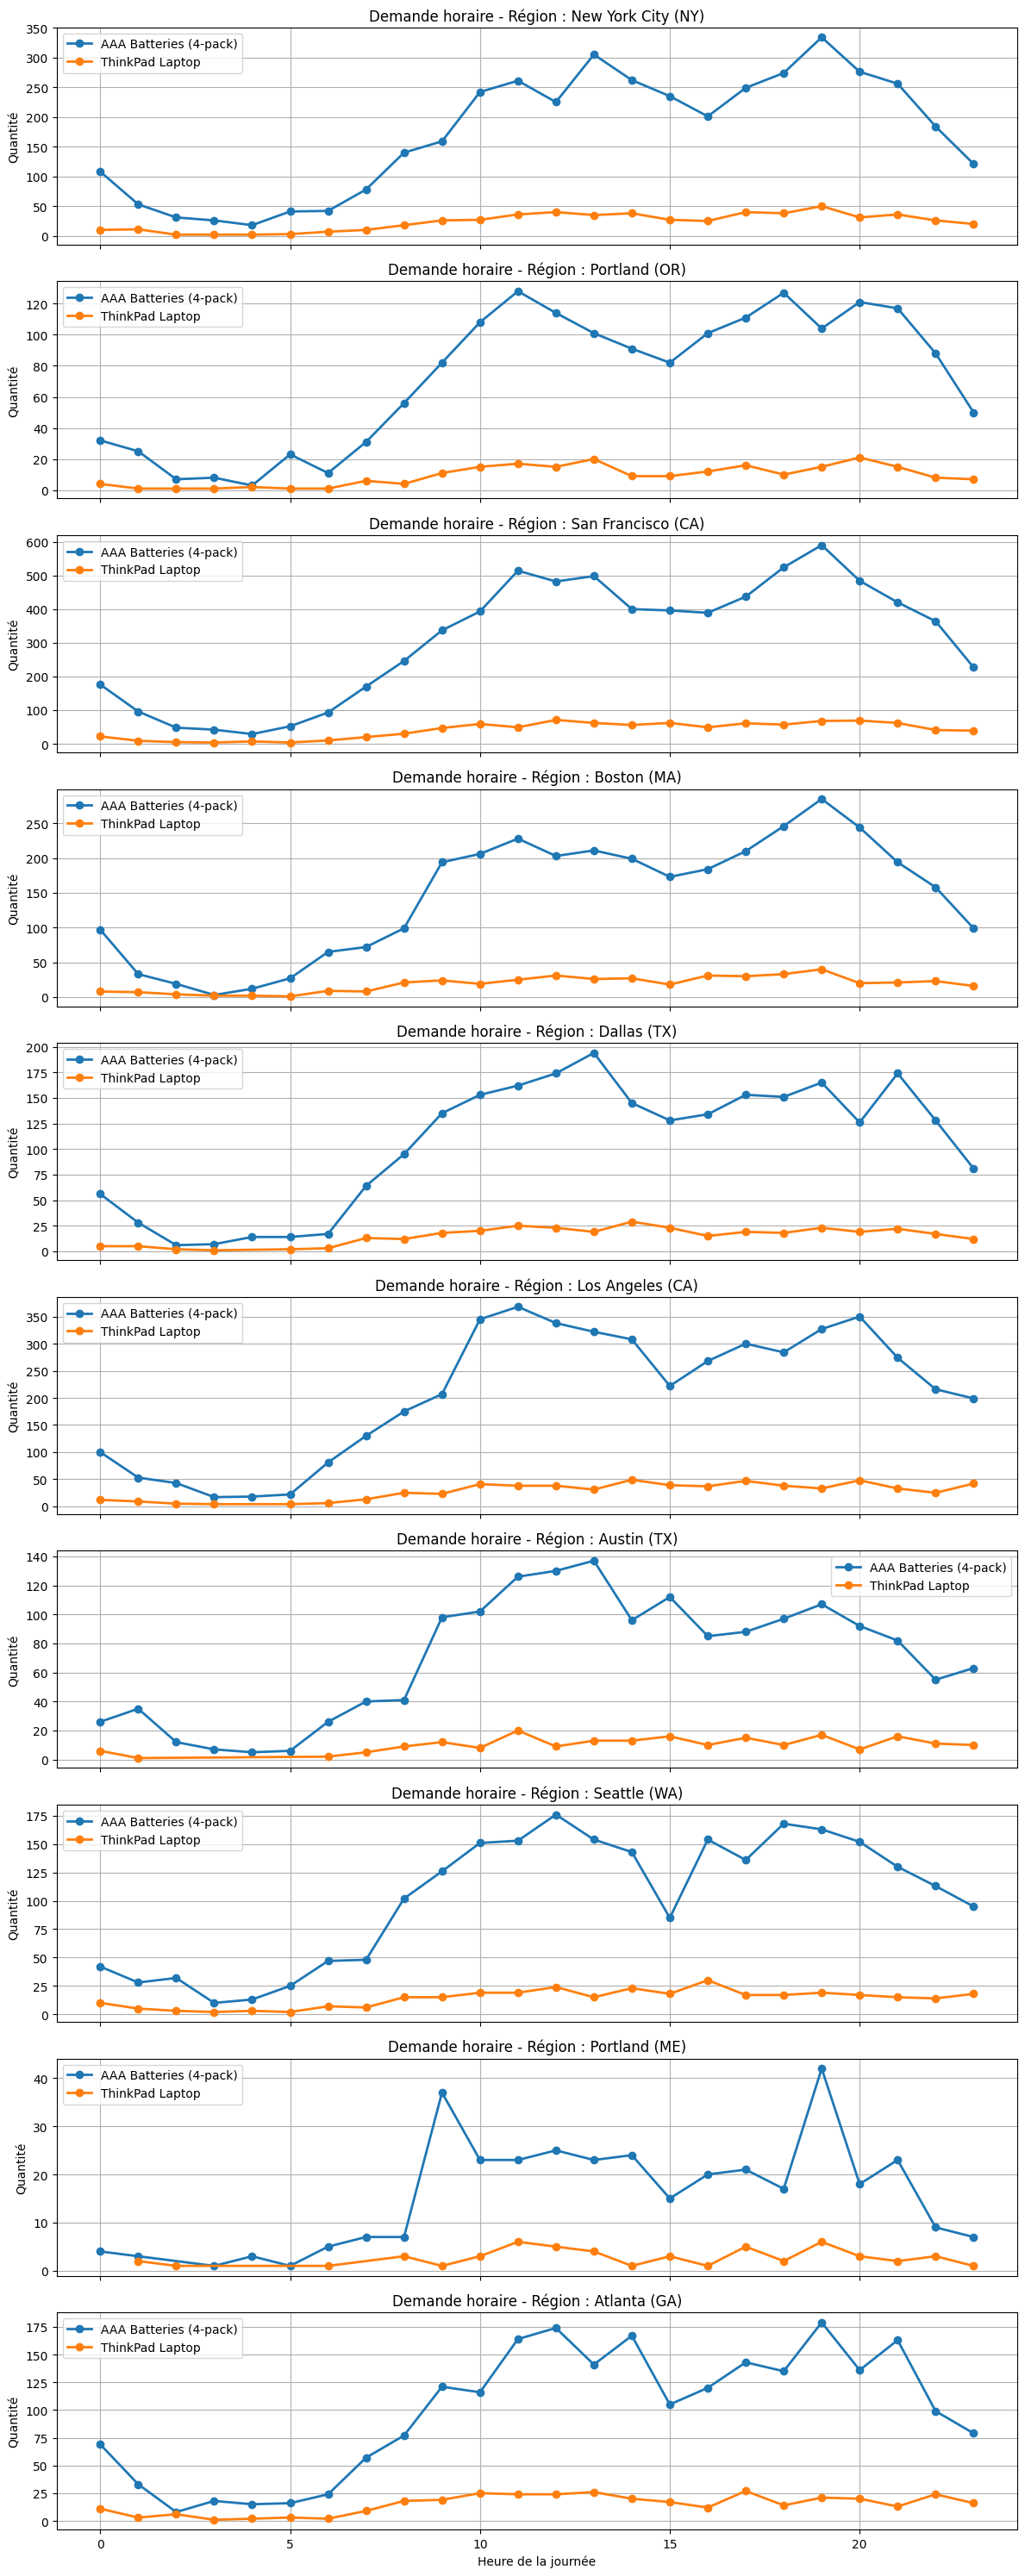

In [18]:
hour_region_product = target_data.groupby(
    ["Hour", "Geographic Zone", "Product"]
)["Quantity Ordered"].sum()

regions = target_data["Geographic Zone"].unique()
products = target_data["Product"].unique()

n_regions = len(regions)
fig, axes = plt.subplots(n_regions, 1, figsize=(12, 3*n_regions), sharex=True)

for ax, region in zip(axes, regions):
    for product in products:
        data = hour_region_product.xs((region, product), level=["Geographic Zone", "Product"], drop_level=False)
        ax.plot(data.index.get_level_values("Hour"), data.values,
                marker="o", linewidth=2, label=f"{product}")

    # Titre + style
    ax.set_title(f"Demande horaire - Région : {region}")
    ax.set_ylabel("Quantité")
    ax.grid(True)
    ax.legend()

plt.xlabel("Heure de la journée")
plt.tight_layout()
plt.show()


## Tendances journalières

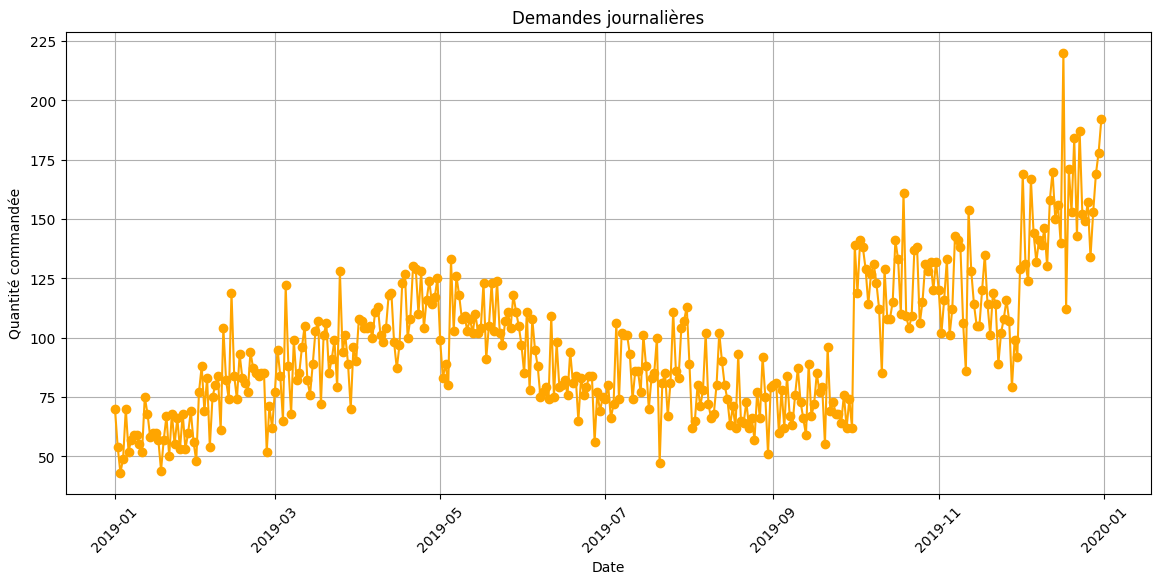

In [19]:

target_data["OnlyDate"] = target_data["Order Date"].dt.date
daily_total = target_data.groupby("OnlyDate")["Quantity Ordered"].sum()

plt.figure(figsize=(14,6))
plt.plot(daily_total.index, daily_total.values, marker="o", color="orange")

plt.xticks(rotation=45)
plt.title("Demandes journalières")
plt.xlabel("Date")
plt.ylabel("Quantité commandée")
plt.grid(True)
plt.show()


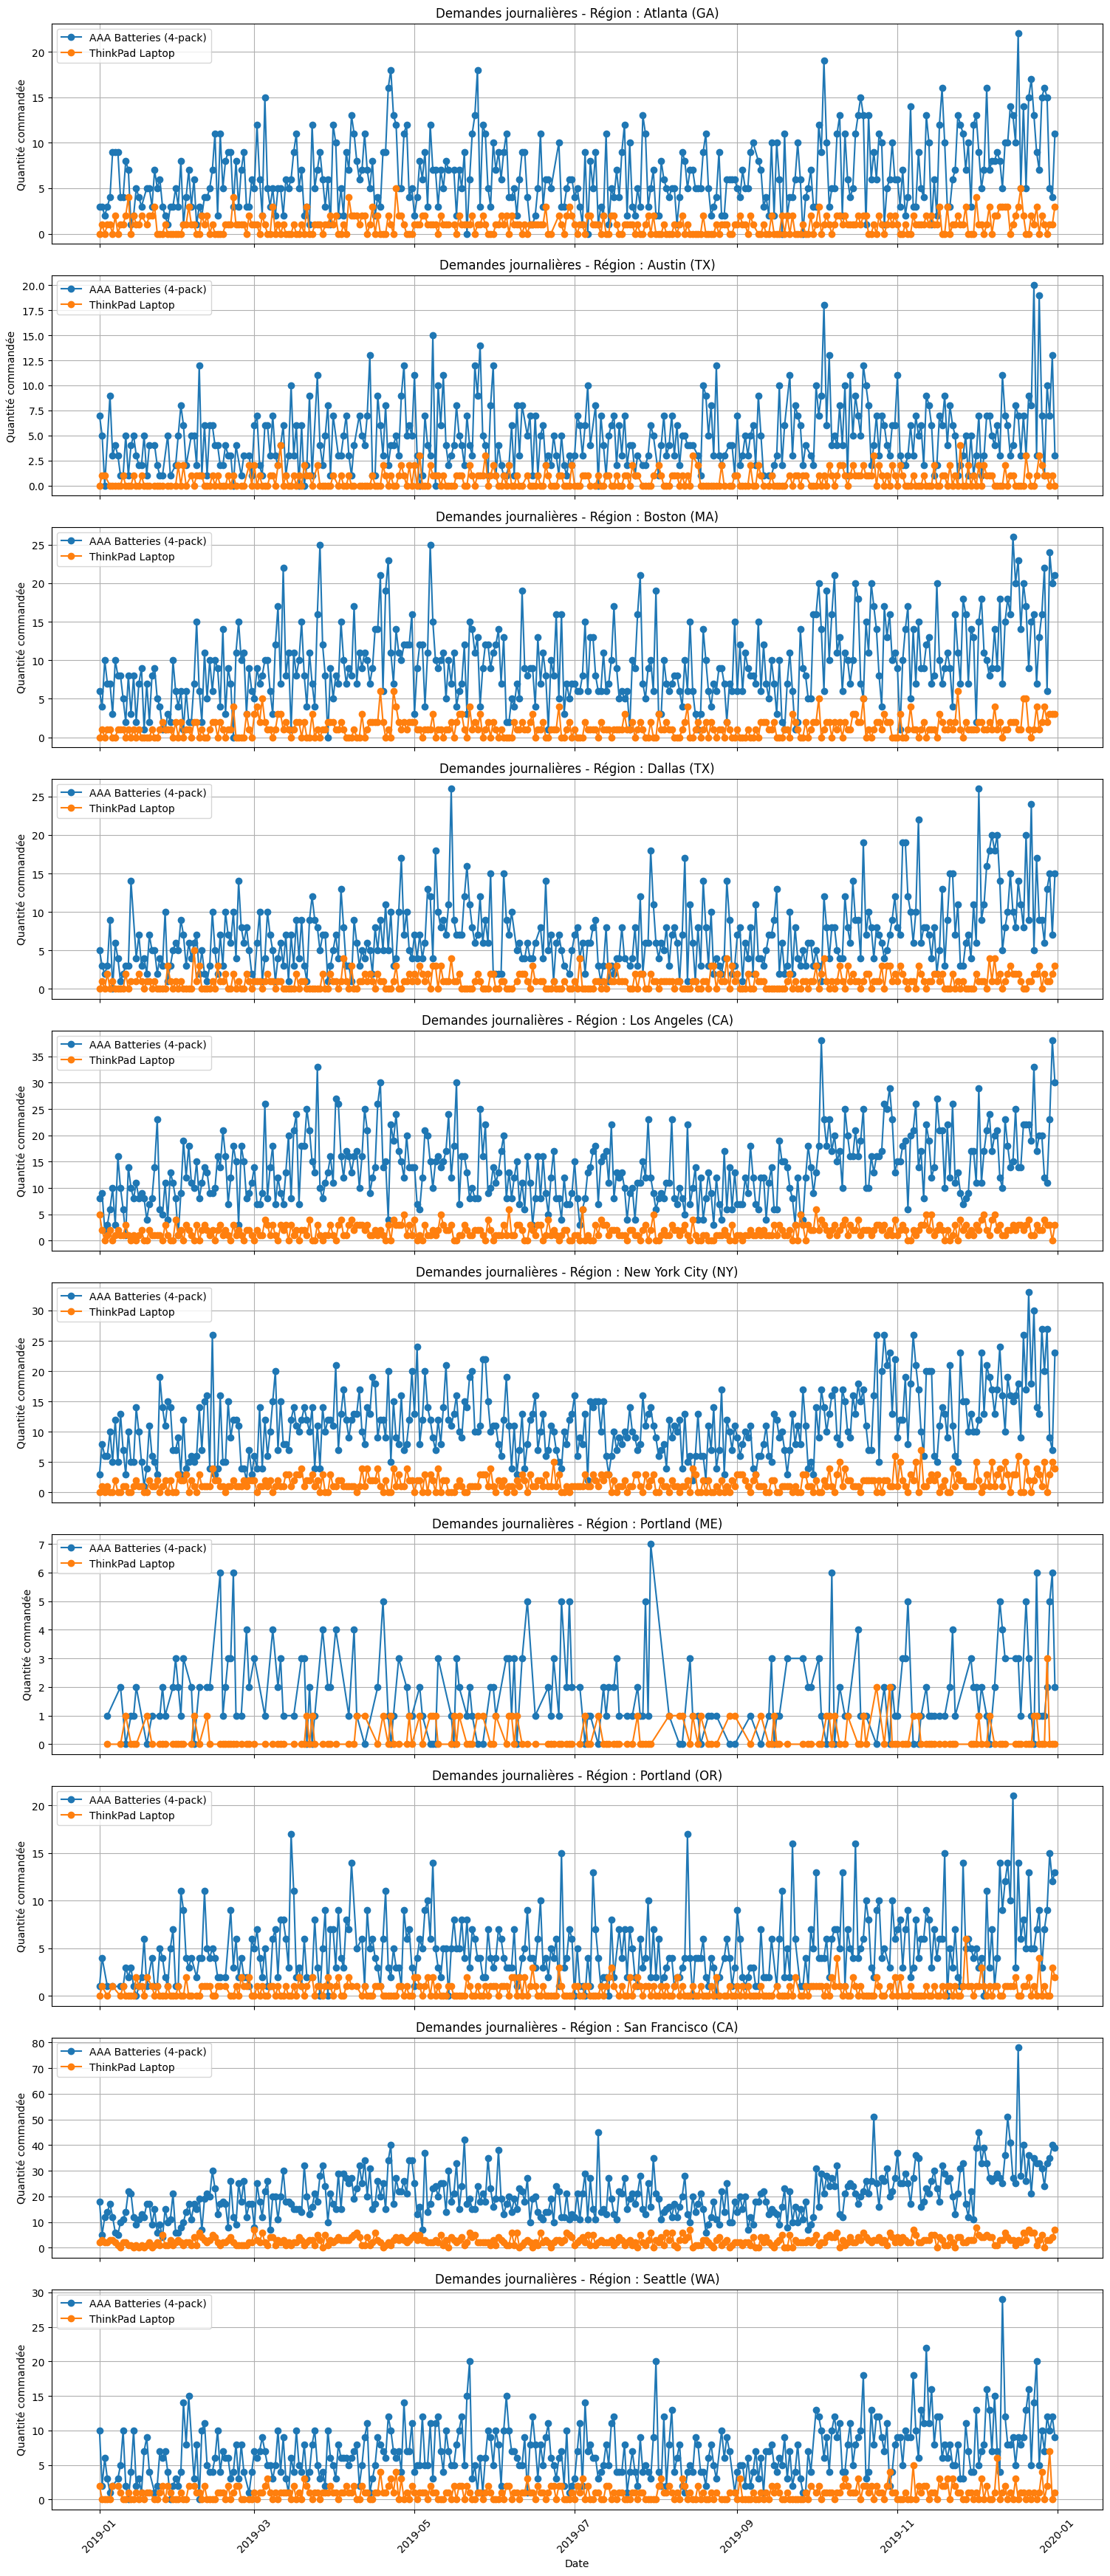

In [20]:
regions = sorted(target_data["Geographic Zone"].unique())
products = sorted(target_data["Product"].unique())
n_regions = len(regions)


fig, axes = plt.subplots(n_regions, 1, figsize=(15, 3.5*n_regions), sharex=True)

for ax, region in zip(axes, regions):
    region_df = target_data[target_data["Geographic Zone"] == region]

    if region_df.empty:
        ax.text(0.5, 0.5, f"Aucune donnée pour la région\n{region}", ha="center", va="center")
        ax.set_title(f"Demandes journalières - Région : {region} (vide)")
        ax.set_ylabel("Quantité")
        continue

    table = (region_df.groupby(["OnlyDate", "Product"])["Quantity Ordered"]
             .sum().unstack().fillna(0))

    for p in products:
        if p not in table.columns:
            table[p] = 0
    table = table[products]

    for product in products:
        ax.plot(table.index, table[product].values, marker="o", label=product)

    ax.set_title(f"Demandes journalières - Région : {region}")
    ax.set_ylabel("Quantité commandée")
    ax.grid(True)
    ax.legend()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


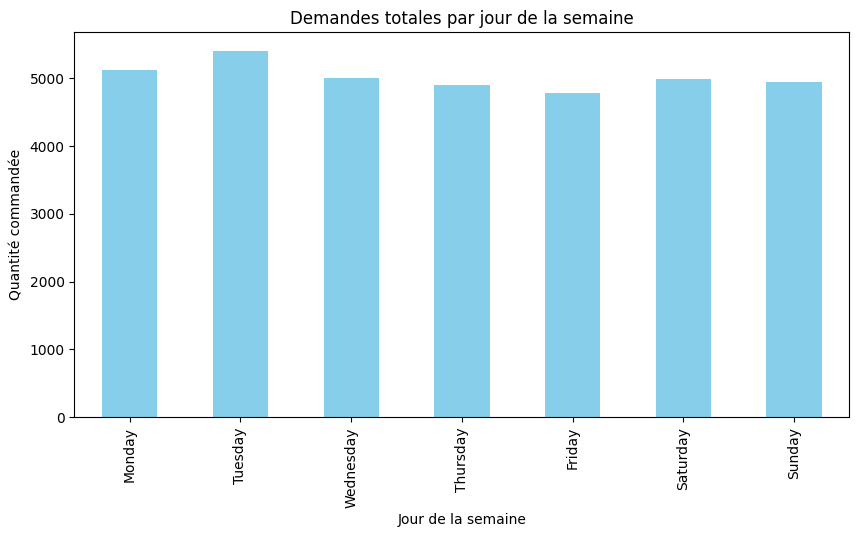

In [21]:
target_data['Weekday'] = target_data['Order Date'].dt.day_name()

daily_demand = target_data.groupby("Day")["Quantity Ordered"].sum()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_demand = target_data.groupby("Weekday")["Quantity Ordered"].sum()
weekday_demand = weekday_demand.reindex(weekday_order)

plt.figure(figsize=(10,5))
weekday_demand.plot(kind="bar", color="skyblue")
plt.title("Demandes totales par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Quantité commandée")
plt.show()

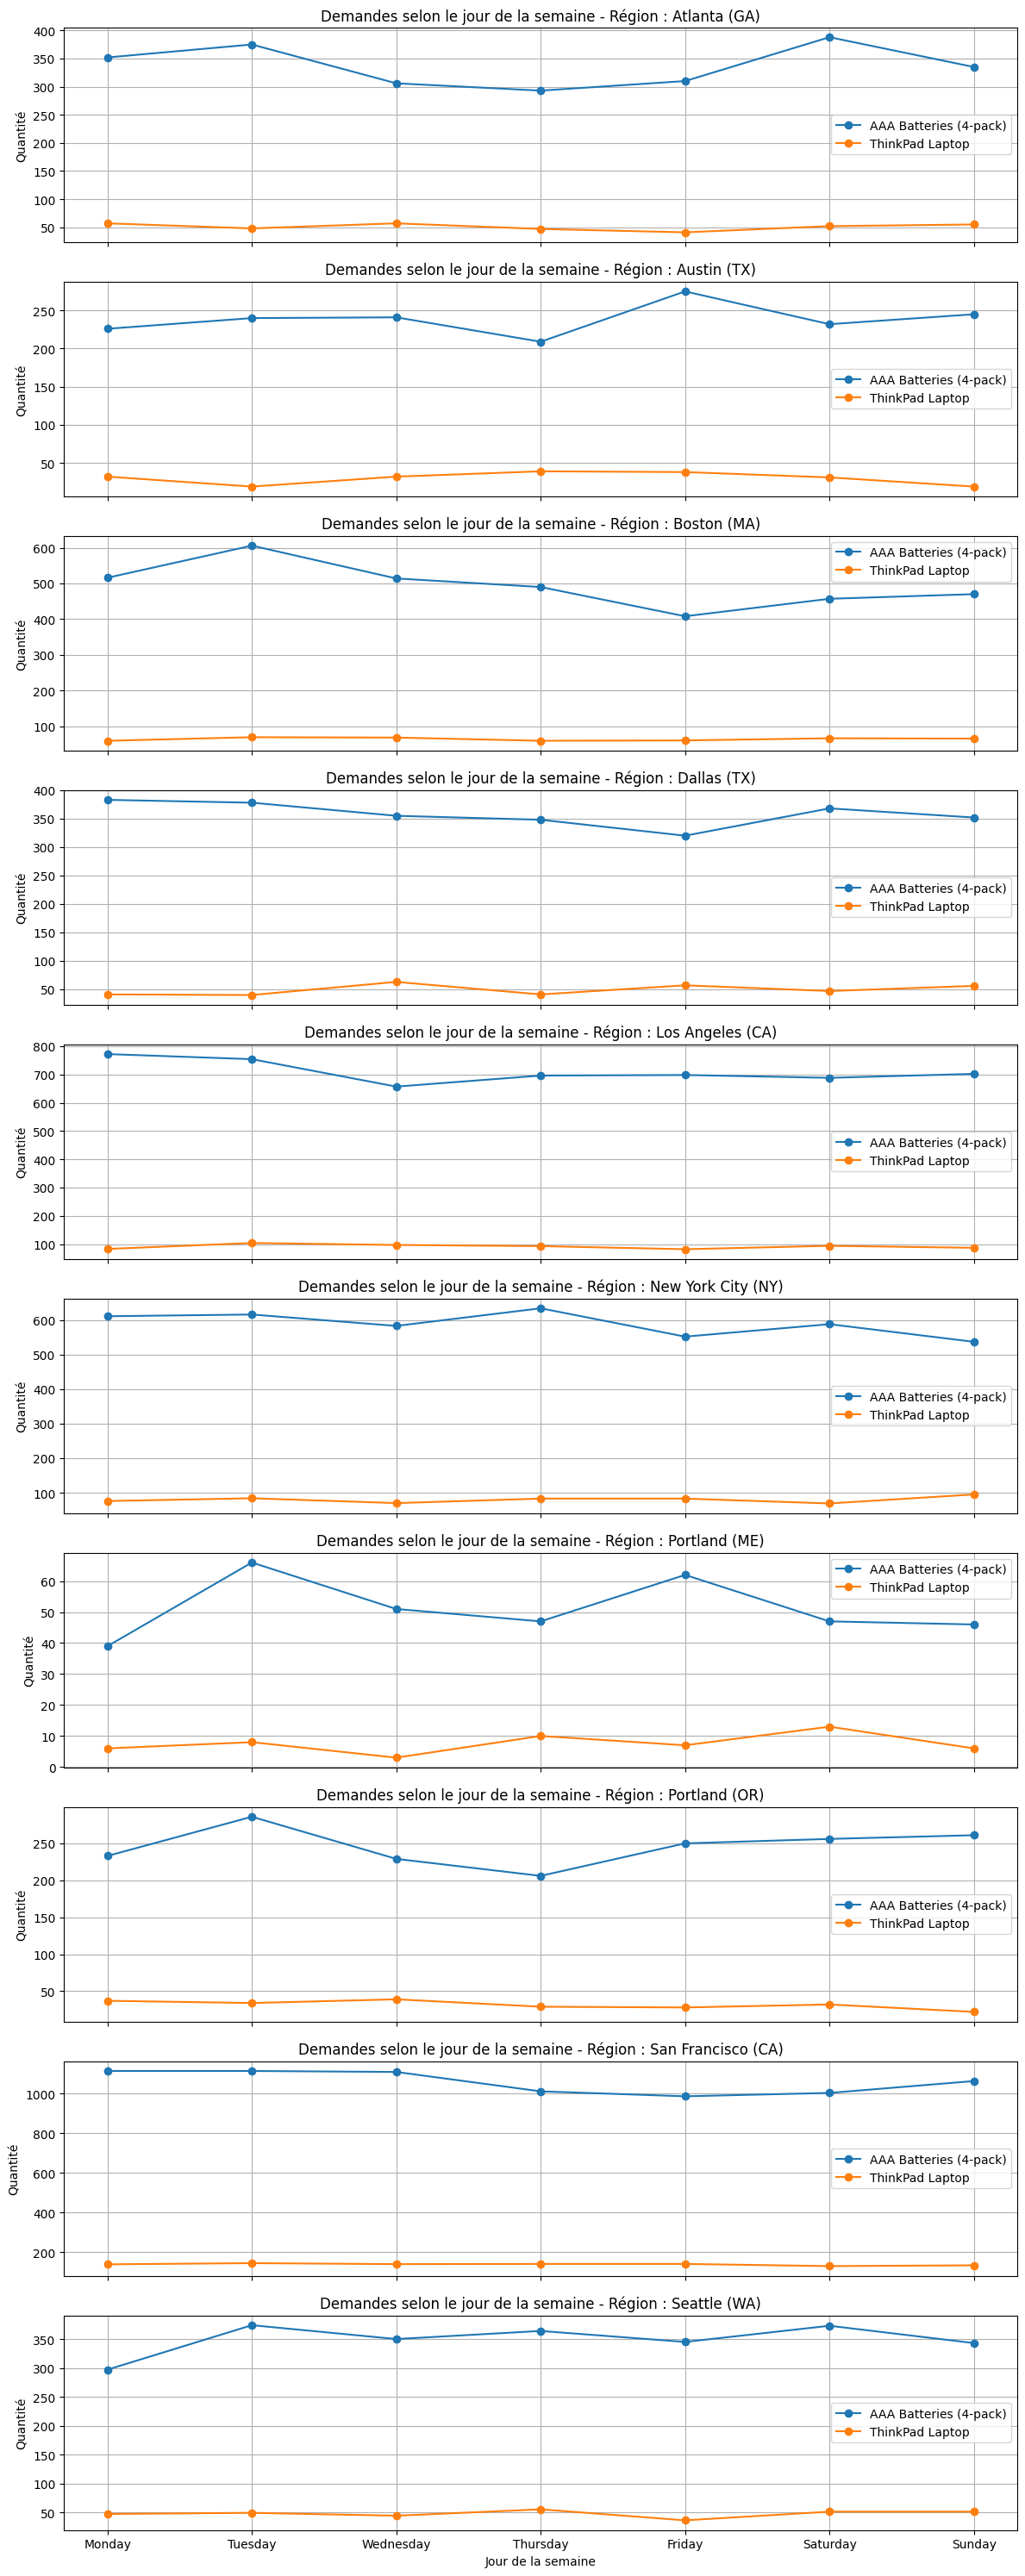

In [22]:
import matplotlib.pyplot as plt
import numpy as np

target_data["Order Date"] = pd.to_datetime(target_data["Order Date"])
target_data["Weekday"] = target_data["Order Date"].dt.day_name()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

regions = sorted(target_data["Geographic Zone"].unique())
products = sorted(target_data["Product"].unique())
n_regions = len(regions)

fig, axes = plt.subplots(n_regions, 1, figsize=(12, 3*n_regions), sharex=True)

for ax, region in zip(axes, regions):
    region_df = target_data[target_data["Geographic Zone"] == region]
    if region_df.empty:
        ax.text(0.5, 0.5, f"Aucune donnée pour la région\n{region}", ha="center", va="center")
        ax.set_title(f"Demandes Selon le jour de la semaine - Région : {region} (vide)")
        ax.set_ylabel("Quantité")
        continue

    table = (region_df.groupby(["Weekday","Product"])["Quantity Ordered"]
             .sum().unstack().reindex(weekday_order).fillna(0))

    for p in products:
        if p not in table.columns:
            table[p] = 0
    table = table[products]

    for product in products:
        ax.plot(table.index, table[product].values, marker="o", label=product)

    ax.set_title(f"Demandes selon le jour de la semaine - Région : {region}")
    ax.set_ylabel("Quantité")
    ax.grid(True)
    ax.legend()

plt.xlabel("Jour de la semaine")
plt.tight_layout()
plt.show()


### Tendances mensuelles

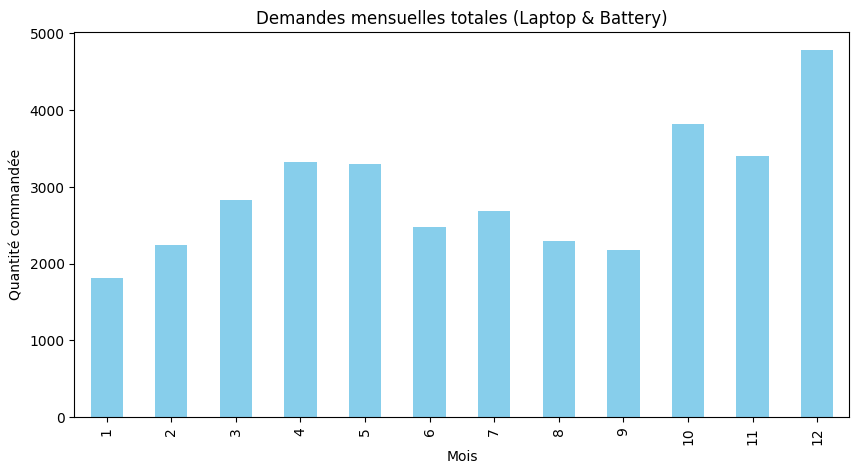

In [23]:
monthly_demand = target_data.groupby("Month")["Quantity Ordered"].sum()

plt.figure(figsize=(10,5))
monthly_demand.plot(kind="bar", color="skyblue")
plt.title("Demandes mensuelles totales (Laptop & Battery)")
plt.xlabel("Mois")
plt.ylabel("Quantité commandée")
plt.show()

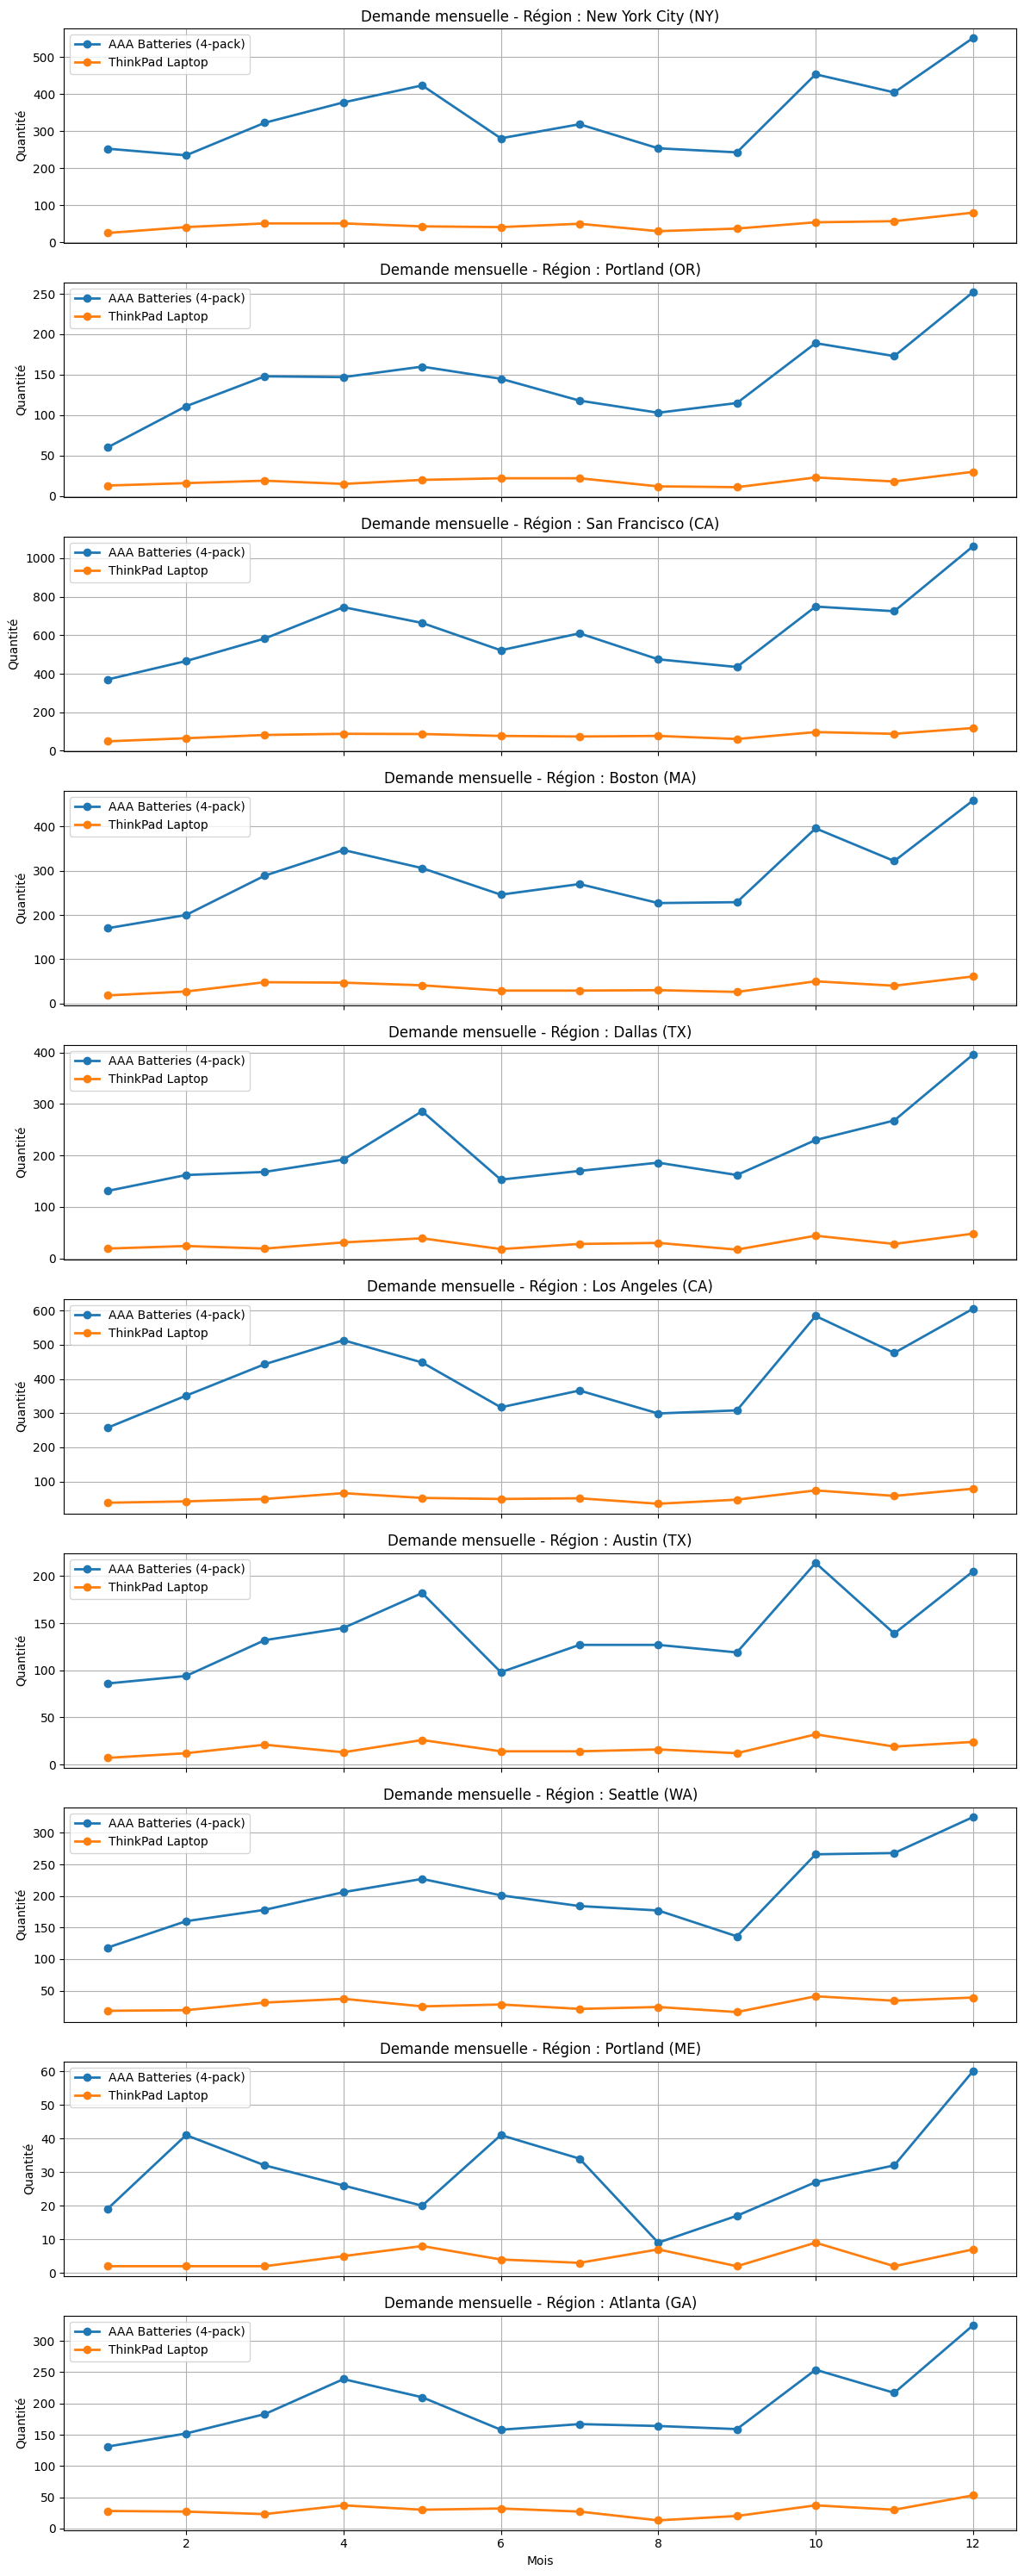

In [24]:
month_region_product = target_data.groupby(
    ["Month", "Geographic Zone", "Product"]
)["Quantity Ordered"].sum()

regions = target_data["Geographic Zone"].unique()
products = target_data["Product"].unique()


n_regions = len(regions)
fig, axes = plt.subplots(n_regions, 1, figsize=(12, 3*n_regions), sharex=True)

for ax, region in zip(axes, regions):
    for product in products:
        data = month_region_product.xs((region, product),
                                       level=["Geographic Zone", "Product"],
                                       drop_level=False)
        ax.plot(data.index.get_level_values("Month"), data.values,
                marker="o", linewidth=2, label=f"{product}")

    ax.set_title(f"Demande mensuelle - Région : {region}")
    ax.set_ylabel("Quantité")
    ax.grid(True)
    ax.legend()

plt.xlabel("Mois")
plt.tight_layout()
plt.show()


### Tendances saisonnière

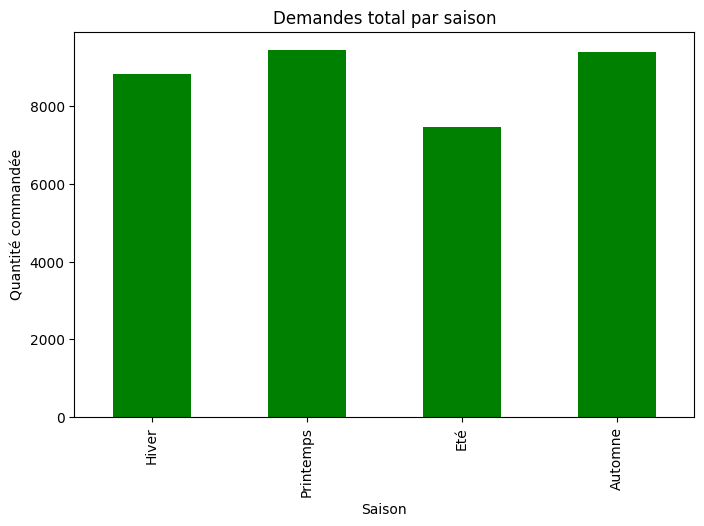

In [25]:
season_demand = target_data.groupby("Season")["Quantity Ordered"].sum()
season_order = ["Hiver", "Printemps", "Eté", "Automne"]
season_demand = season_demand.reindex(season_order)

plt.figure(figsize=(8,5))
season_demand.plot(kind="bar", color="green")
plt.title("Demandes total par saison")
plt.xlabel("Saison")
plt.ylabel("Quantité commandée")
plt.show()

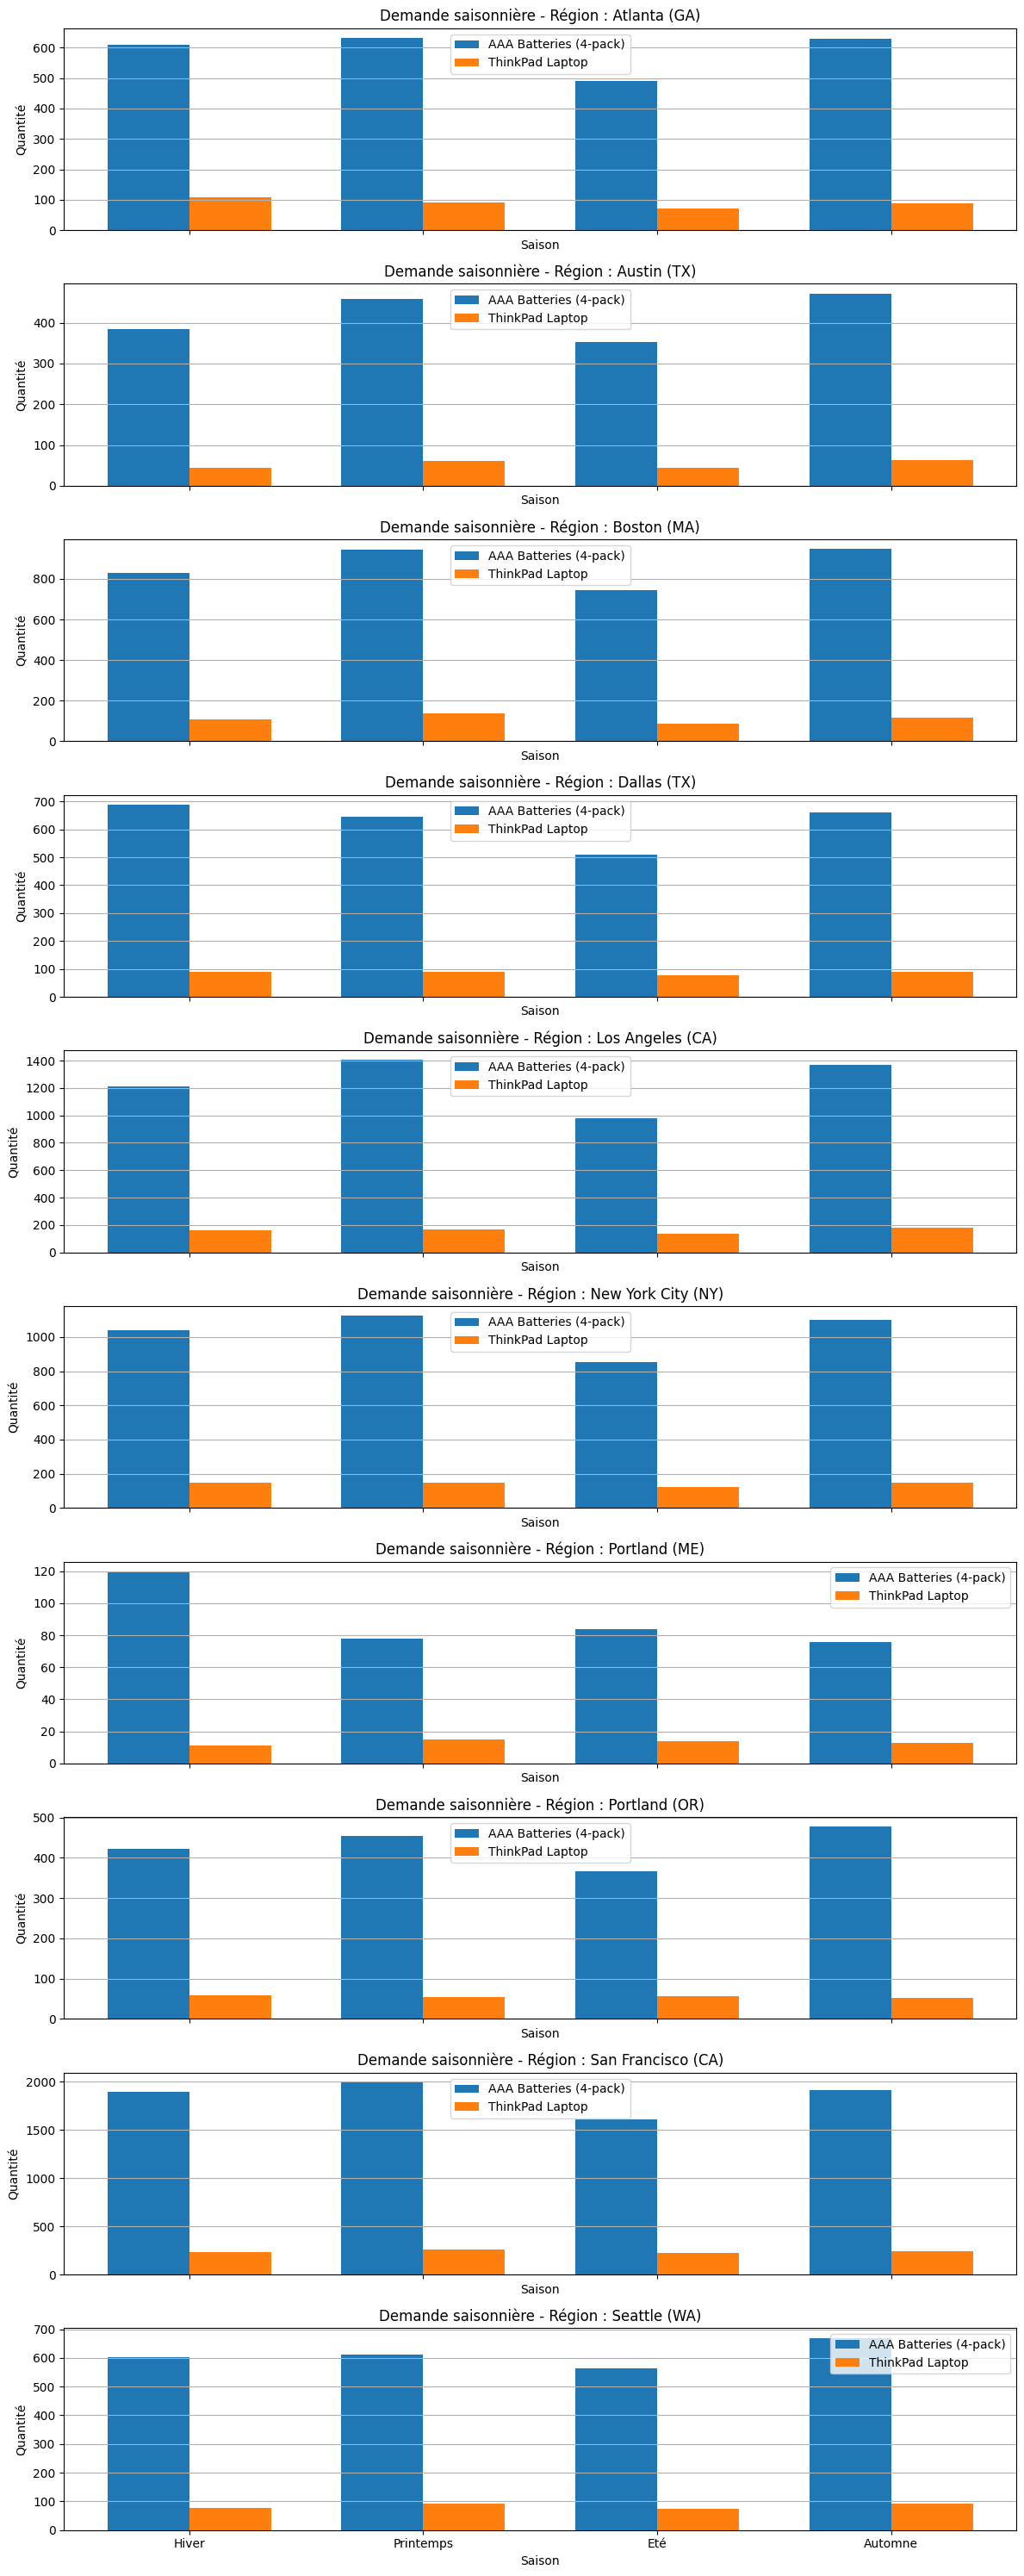

In [26]:
required_cols = {"Season", "Geographic Zone", "Product", "Quantity Ordered"}
missing = required_cols - set(target_data.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans target_data: {missing}")

season_order = ["Hiver", "Printemps", "Eté", "Automne"]
regions = sorted(target_data["Geographic Zone"].unique())
products = sorted(target_data["Product"].unique())
n_regions = len(regions)
n_products = len(products)

fig, axes = plt.subplots(n_regions, 1, figsize=(12, 3*n_regions), sharex=True)

bar_width = 0.35
x = np.arange(len(season_order))

for ax, region in zip(axes, regions):
    region_df = target_data[target_data["Geographic Zone"] == region]
    if region_df.empty:
        ax.text(0.5, 0.5, f"Aucune donnée pour la région\n{region}", ha="center", va="center")
        ax.set_title(f"Demande saisonnière - Région : {region} (vide)")
        ax.set_ylabel("Quantité")
        continue

    table = region_df.groupby(["Season", "Product"])["Quantity Ordered"].sum().unstack().reindex(season_order).fillna(0)
    for p in products:
        if p not in table.columns:
            table[p] = 0
    table = table[products]

    for i, product in enumerate(products):
        ax.bar(x + i*bar_width, table[product].values, width=bar_width, label=product)

    ax.set_title(f"Demande saisonnière - Région : {region}")
    ax.set_ylabel("Quantité")
    ax.set_xlabel("Saison")
    ax.set_xticks(x + bar_width*(n_products-1)/2)
    ax.set_xticklabels(season_order)
    ax.legend()
    ax.grid(axis="y")

plt.xlabel("Saison")
plt.tight_layout()
plt.show()


# Modèle de prédiction

On va maintenant construire un modèle pour prédire quelle zone géographique aura le plus de demande pour les 2 produits. Nous allons assimiler le problème en un  "Time Series Forcasting".

## Prédiction par mois

In [27]:
time_series_data = target_data.groupby(['Month', 'Geographic Zone', 'Product'])['Quantity Ordered'].sum().reset_index()
time_series_data

Month     Geographic Zone                 Product  Quantity Ordered
0        1        Atlanta (GA)  AAA Batteries (4-pack)               131
1        1        Atlanta (GA)         ThinkPad Laptop                28
2        1         Austin (TX)  AAA Batteries (4-pack)                86
3        1         Austin (TX)         ThinkPad Laptop                 7
4        1         Boston (MA)  AAA Batteries (4-pack)               170
..     ...                 ...                     ...               ...
235     12       Portland (OR)         ThinkPad Laptop                30
236     12  San Francisco (CA)  AAA Batteries (4-pack)              1062
237     12  San Francisco (CA)         ThinkPad Laptop               118
238     12        Seattle (WA)  AAA Batteries (4-pack)               325
239     12        Seattle (WA)         ThinkPad Laptop                39

[240 rows x 4 columns]

## Feature Engineering

Rajoutons à notre dataset des features temporelles, notamment des "lags" sur les 3 derniers mois, et une moyenne mobile

In [28]:
for i in range(2):
  time_series_data[f"Lag {i+1}"] = time_series_data.groupby(["Geographic Zone", "Product"])["Quantity Ordered"].shift(i+1)

time_series_data["Rolling Mean 3"] = time_series_data.groupby(["Geographic Zone", "Product"])["Quantity Ordered"].shift(1).rolling(3,min_periods=1).mean()
time_series_data["Rolling_7"] = time_series_data.groupby(["Geographic Zone","Product"])["Quantity Ordered"].shift(1).rolling(7, min_periods=1).mean()
time_series_data["Rolling_STD_7"] = time_series_data.groupby(["Geographic Zone","Product"])["Quantity Ordered"].shift(1).rolling(7, min_periods=1).std()
time_series_data = time_series_data.dropna()
time_series_data

Month     Geographic Zone                 Product  Quantity Ordered  \
40       3        Atlanta (GA)  AAA Batteries (4-pack)               183   
41       3        Atlanta (GA)         ThinkPad Laptop                23   
42       3         Austin (TX)  AAA Batteries (4-pack)               132   
43       3         Austin (TX)         ThinkPad Laptop                21   
44       3         Boston (MA)  AAA Batteries (4-pack)               289   
..     ...                 ...                     ...               ...   
235     12       Portland (OR)         ThinkPad Laptop                30   
236     12  San Francisco (CA)  AAA Batteries (4-pack)              1062   
237     12  San Francisco (CA)         ThinkPad Laptop               118   
238     12        Seattle (WA)  AAA Batteries (4-pack)               325   
239     12        Seattle (WA)         ThinkPad Laptop                39   

     Lag 1  Lag 2  Rolling Mean 3   Rolling_7  Rolling_STD_7  
40   152.0  131.0       96.000000  111.428571     124.838372  
41    27.0   28.0       65.666667  106.714286     127.694576  
42    94.0   86.0       91.000000  118.285714     121.296763  
43    12.0    7.0       44.333333   67.142857      54.627309  
44   200.0  170.0      102.000000   88.714286      72.994781  
..     ...    ...             ...         ...            ...  
235   18.0   23.0       64.333333  106.428571     142.962533  
236  725.0  749.0      305.333333  201.714286     270.604086  
237   88.0   97.0      277.000000  156.428571     257.102351  
238  268.0  266.0      360.333333  186.571429     255.868363  
239   34.0   41.0      130.000000  186.857143     255.668033  

[200 rows x 9 columns]

Encodage des features Geographic Zone et Product

In [29]:
product_encoder = LabelEncoder()
zone_encoder = LabelEncoder()

time_series_data["Product"] = product_encoder.fit_transform(time_series_data["Product"])
time_series_data["Geographic Zone"] = zone_encoder.fit_transform(time_series_data["Geographic Zone"])

time_series_data

/tmp/ipython-input-2619740126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_data["Product"] = product_encoder.fit_transform(time_series_data["Product"])
/tmp/ipython-input-2619740126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_data["Geographic Zone"] = zone_encoder.fit_transform(time_series_data["Geographic Zone"])


Month  Geographic Zone  Product  Quantity Ordered  Lag 1  Lag 2  \
40       3                0        0               183  152.0  131.0   
41       3                0        1                23   27.0   28.0   
42       3                1        0               132   94.0   86.0   
43       3                1        1                21   12.0    7.0   
44       3                2        0               289  200.0  170.0   
..     ...              ...      ...               ...    ...    ...   
235     12                7        1                30   18.0   23.0   
236     12                8        0              1062  725.0  749.0   
237     12                8        1               118   88.0   97.0   
238     12                9        0               325  268.0  266.0   
239     12                9        1                39   34.0   41.0   

     Rolling Mean 3   Rolling_7  Rolling_STD_7  
40        96.000000  111.428571     124.838372  
41        65.666667  106.714286     127.694576  
42        91.000000  118.285714     121.296763  
43        44.333333   67.142857      54.627309  
44       102.000000   88.714286      72.994781  
..              ...         ...            ...  
235       64.333333  106.428571     142.962533  
236      305.333333  201.714286     270.604086  
237      277.000000  156.428571     257.102351  
238      360.333333  186.571429     255.868363  
239      130.000000  186.857143     255.668033  

[200 rows x 9 columns]

Création des train_set et test_set

In [30]:
time_series_data = time_series_data.sort_values(by=["Month", "Geographic Zone", "Product"])
train_data = time_series_data[time_series_data["Month"] < 11]
test_data = time_series_data[time_series_data["Month"].isin([11, 12])]

X_train = train_data[["Month","Geographic Zone","Product","Lag 1","Lag 2"]]
y_train = train_data["Quantity Ordered"]

X_test = test_data[["Month","Geographic Zone","Product","Lag 1","Lag 2"]]
y_test = test_data["Quantity Ordered"]

Entraînement du modèle

In [31]:
import lightgbm as lgb
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist"
)

param_grid = {
    'learning_rate': [0.2, 0.1, 0.05, 0.01],
    'max_depth': [2, 4, 8, 16]
}

tscv = TimeSeriesSplit(n_splits=3)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    xgb_model,
    param_grid,
    cv=tscv,
    scoring=mae_scorer,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'learning_rate': 0.01, 'max_depth': 2}


Test d'inférence sur les données test pour voir les performances de notre modèle

MAE sur test set = 49.83
RMSE sur test set = 89.90


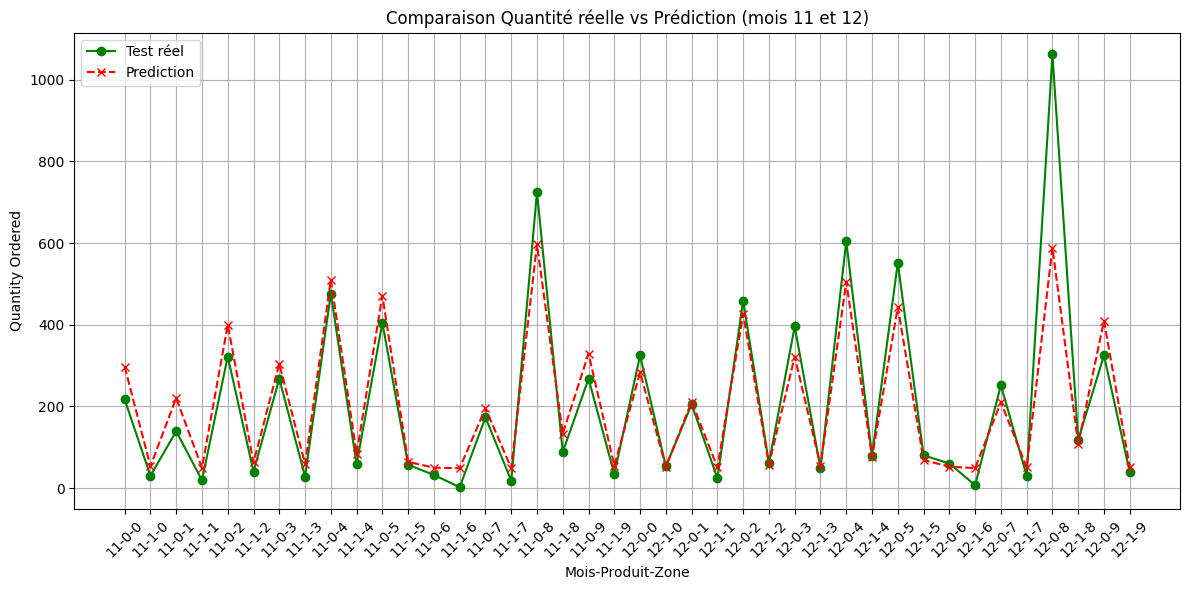

In [32]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred.astype(int))
rmse = np.sqrt(mean_squared_error(y_test, y_pred.astype(int)))

print(f"MAE sur test set = {mae:.2f}")
print(f"RMSE sur test set = {rmse:.2f}")

X_test_plot = X_test.copy()
X_test_plot['Label'] = X_test_plot['Month'].astype(str) + "-" + \
                       X_test_plot['Product'].astype(str) + "-" + \
                       X_test_plot['Geographic Zone'].astype(str)

plt.figure(figsize=(12,6))

plt.plot(X_test_plot['Label'], y_test.values, label='Test réel', color='green', marker='o')
plt.plot(X_test_plot['Label'], y_pred, label='Prediction', color='red', linestyle='--', marker='x')

plt.title("Comparaison Quantité réelle vs Prédiction (mois 11 et 12)")
plt.xlabel("Mois-Produit-Zone")
plt.ylabel("Quantity Ordered")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Prédiction par  jour

Due au peu de données que l'on dispose si on aggrege par mois, par région et par produit (seulement 12*10*2), nous n'avons pas spécialement obtenue de bonne performance
Considérons cette fois une approche par jour

In [33]:
time_series_daily = target_data.groupby(['OnlyDate', 'Geographic Zone', 'Product'])['Quantity Ordered'].sum().reset_index()
time_series_daily

OnlyDate     Geographic Zone                 Product  Quantity Ordered
0     2019-01-01        Atlanta (GA)  AAA Batteries (4-pack)                 3
1     2019-01-01         Austin (TX)  AAA Batteries (4-pack)                 7
2     2019-01-01         Boston (MA)  AAA Batteries (4-pack)                 6
3     2019-01-01         Dallas (TX)  AAA Batteries (4-pack)                 5
4     2019-01-01    Los Angeles (CA)  AAA Batteries (4-pack)                 8
...          ...                 ...                     ...               ...
5566  2019-12-31       Portland (OR)         ThinkPad Laptop                 2
5567  2019-12-31  San Francisco (CA)  AAA Batteries (4-pack)                39
5568  2019-12-31  San Francisco (CA)         ThinkPad Laptop                 7
5569  2019-12-31        Seattle (WA)  AAA Batteries (4-pack)                 9
5570  2019-12-31        Seattle (WA)         ThinkPad Laptop                 1

[5571 rows x 4 columns]

### Modèle Prophet

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Atlanta (GA) | MAE=3.95, RMSE=4.96


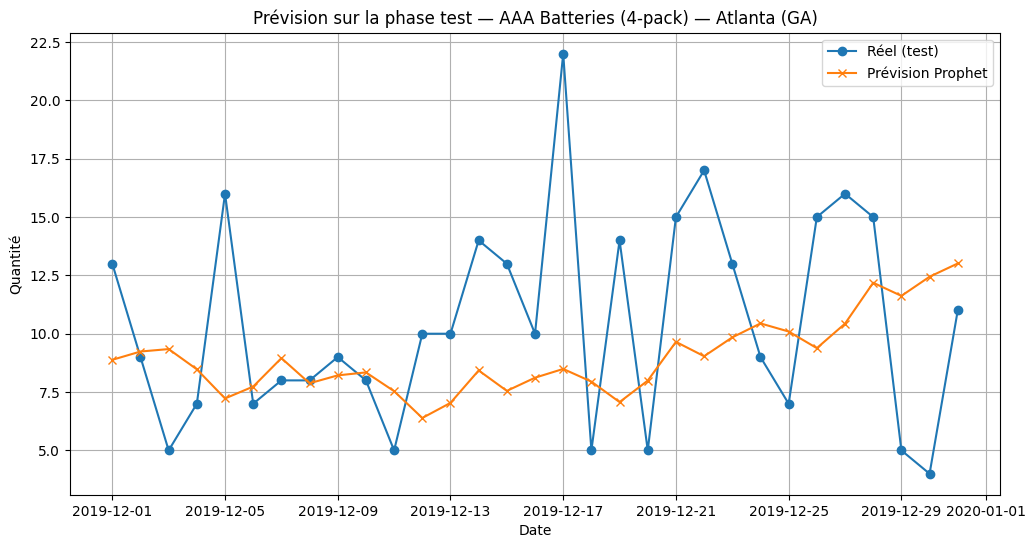

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Austin (TX) | MAE=5.34, RMSE=6.94


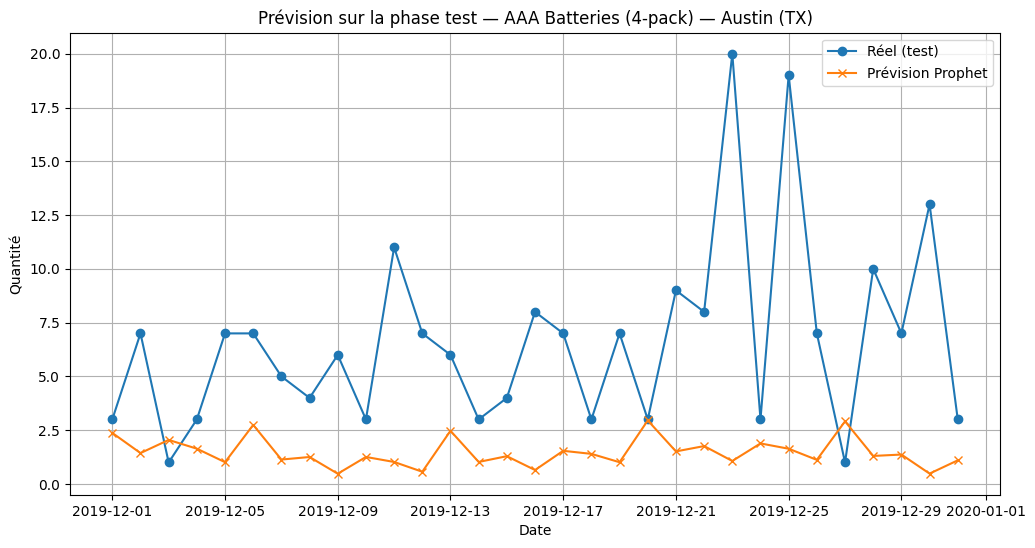

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Boston (MA) | MAE=5.13, RMSE=6.08


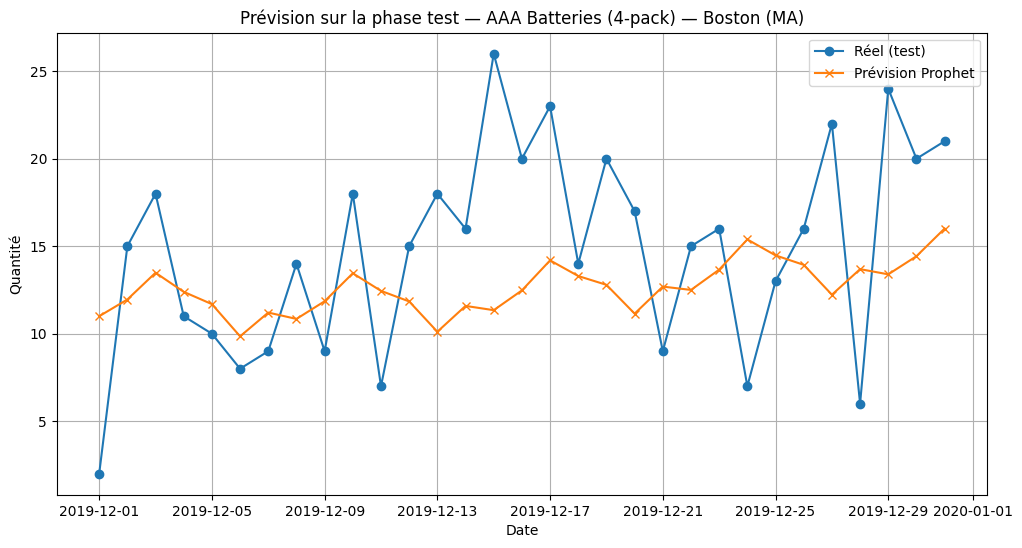

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Dallas (TX) | MAE=5.56, RMSE=7.37


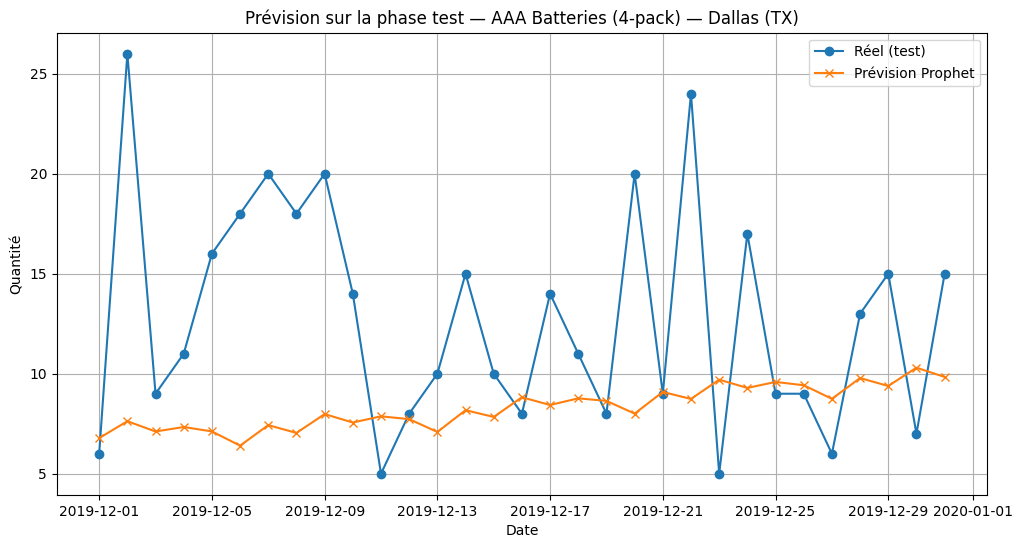

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Los Angeles (CA) | MAE=11.28, RMSE=12.85


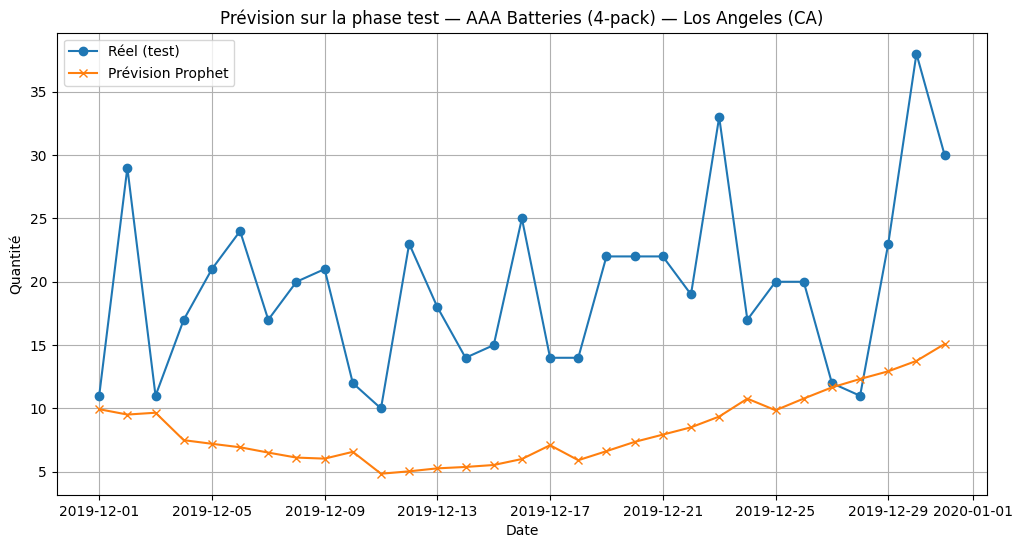

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — New York City (NY) | MAE=6.11, RMSE=7.58


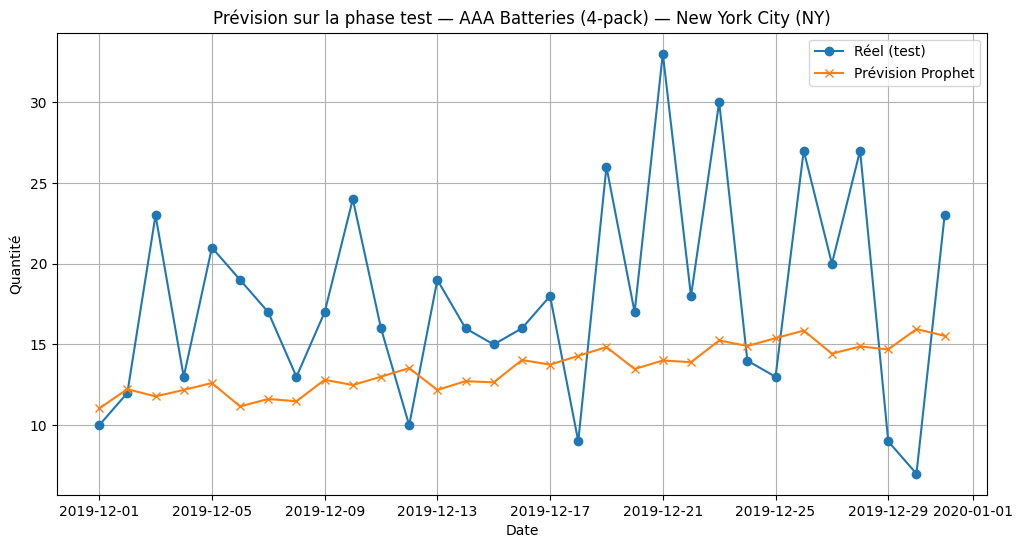

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Portland (OR) | MAE=4.14, RMSE=5.32


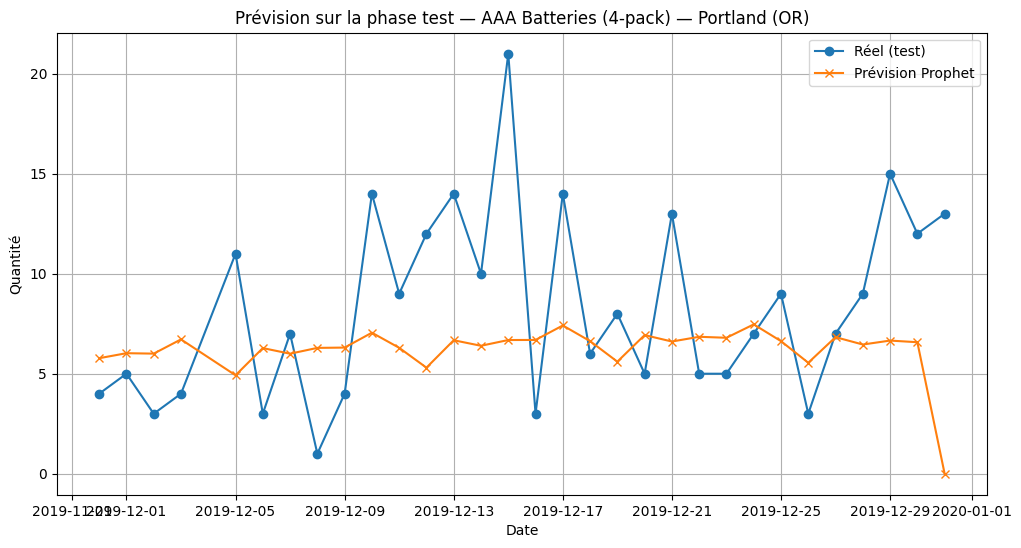

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — San Francisco (CA) | MAE=23.91, RMSE=26.31


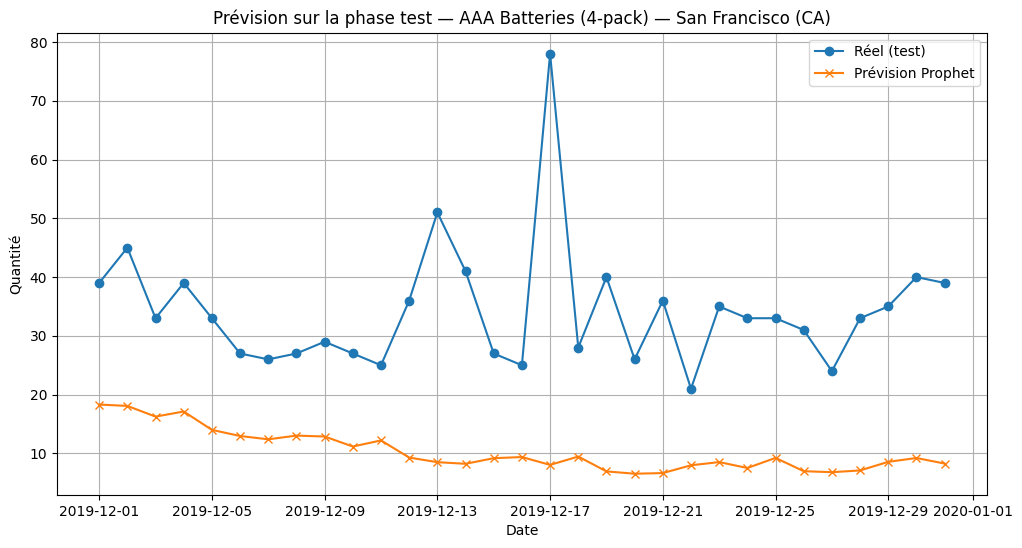

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Seattle (WA) | MAE=9.13, RMSE=10.47


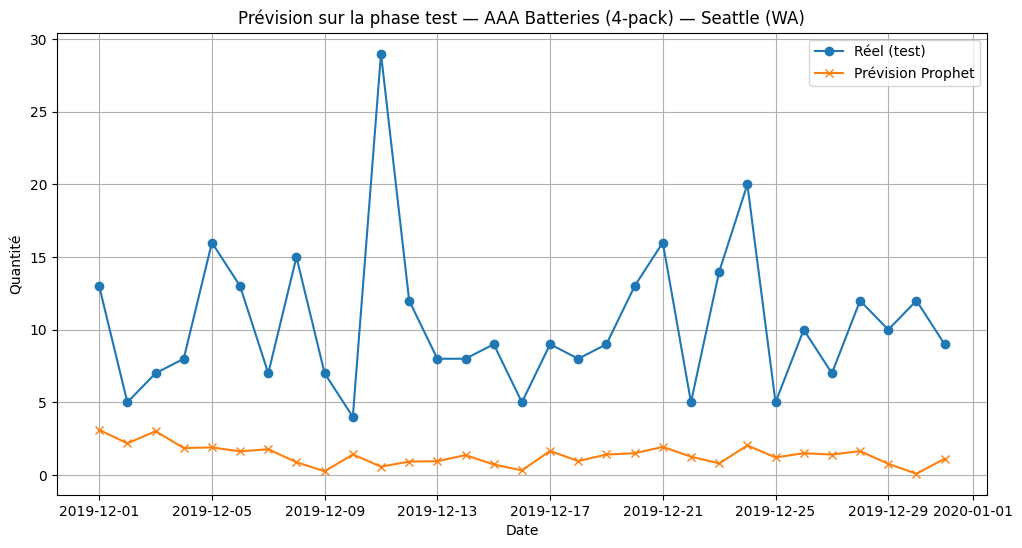

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : AAA Batteries (4-pack) — Portland (ME) | MAE=1.91, RMSE=2.52


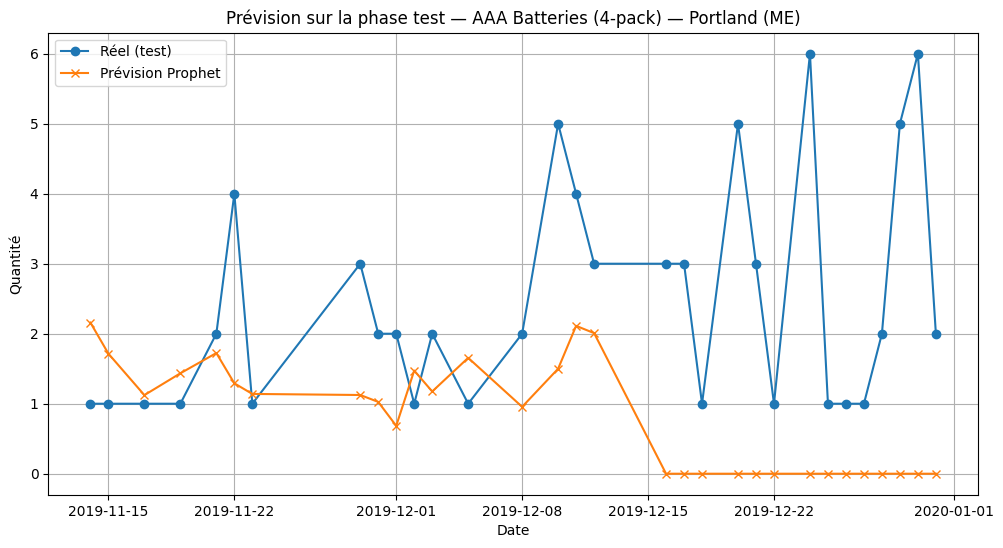

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Atlanta (GA) | MAE=1.29, RMSE=1.53


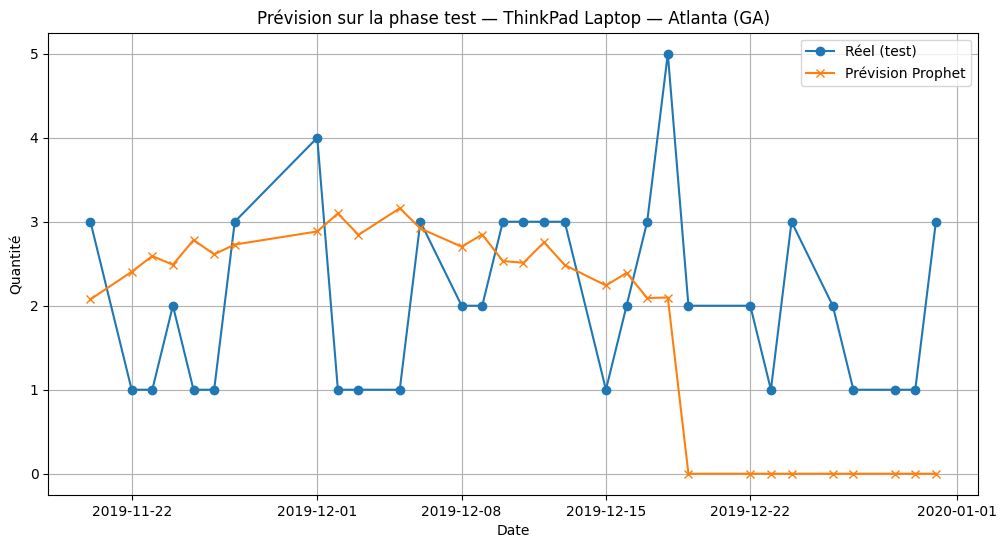

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Austin (TX) | MAE=1.14, RMSE=1.39


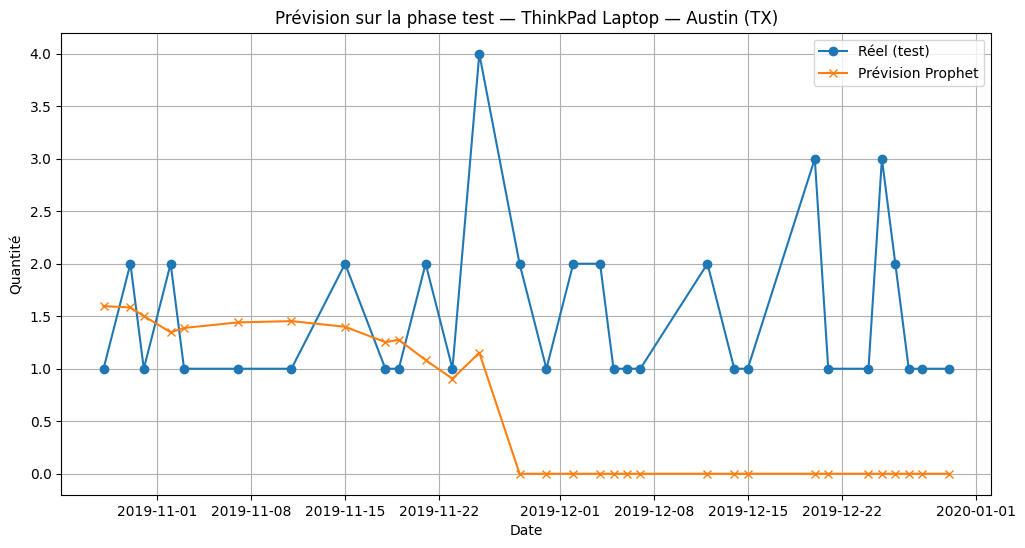

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Boston (MA) | MAE=1.18, RMSE=1.58


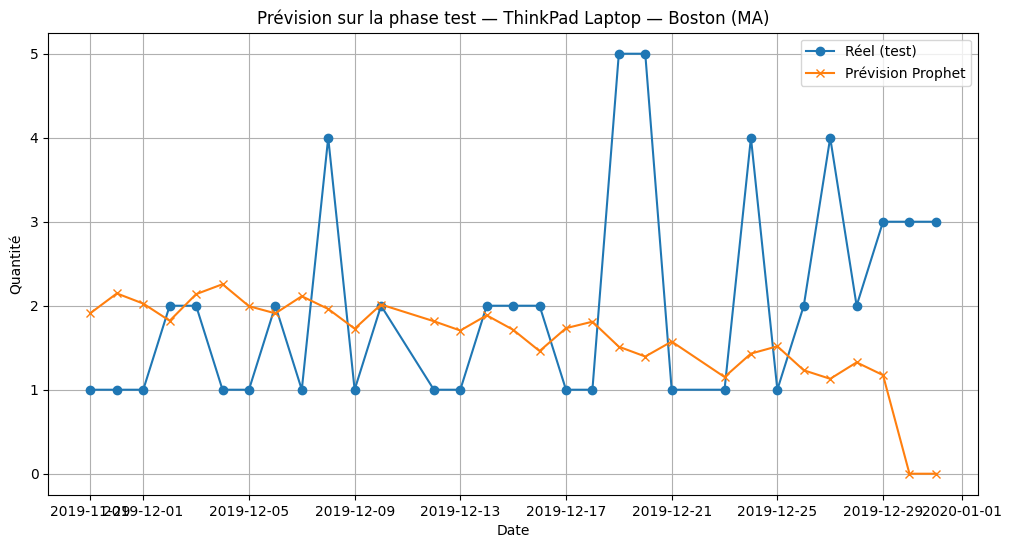

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Dallas (TX) | MAE=1.04, RMSE=1.31


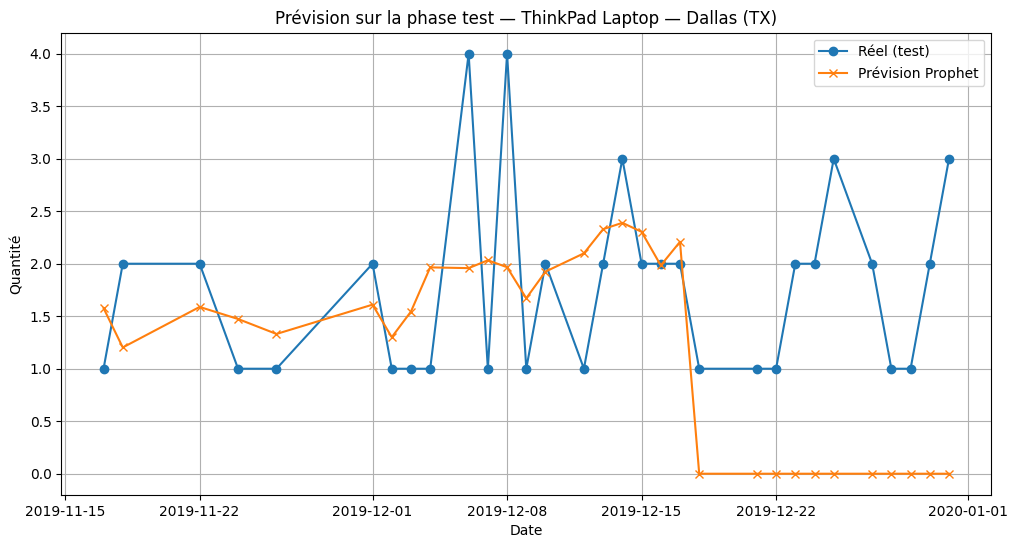

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Los Angeles (CA) | MAE=1.53, RMSE=1.88


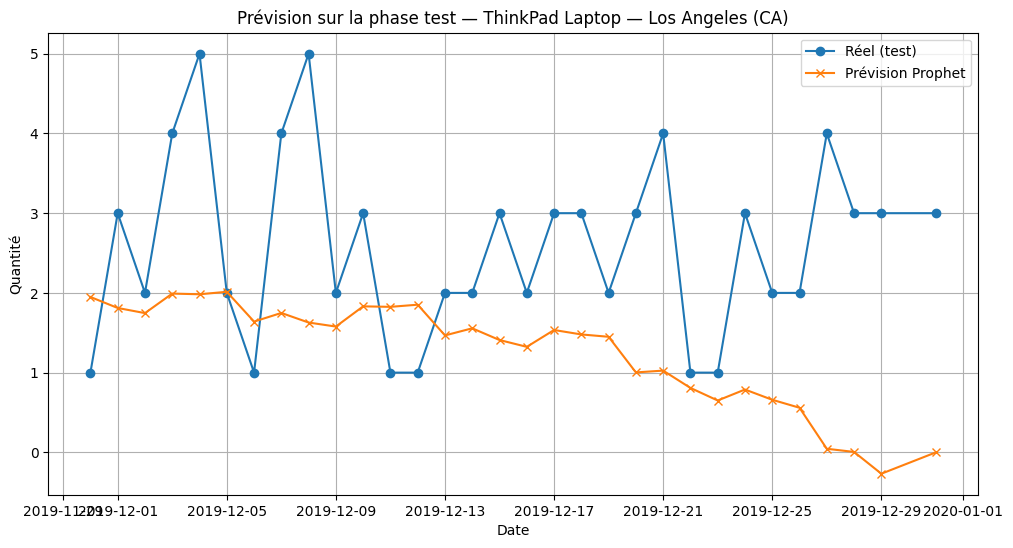

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — New York City (NY) | MAE=1.51, RMSE=2.00


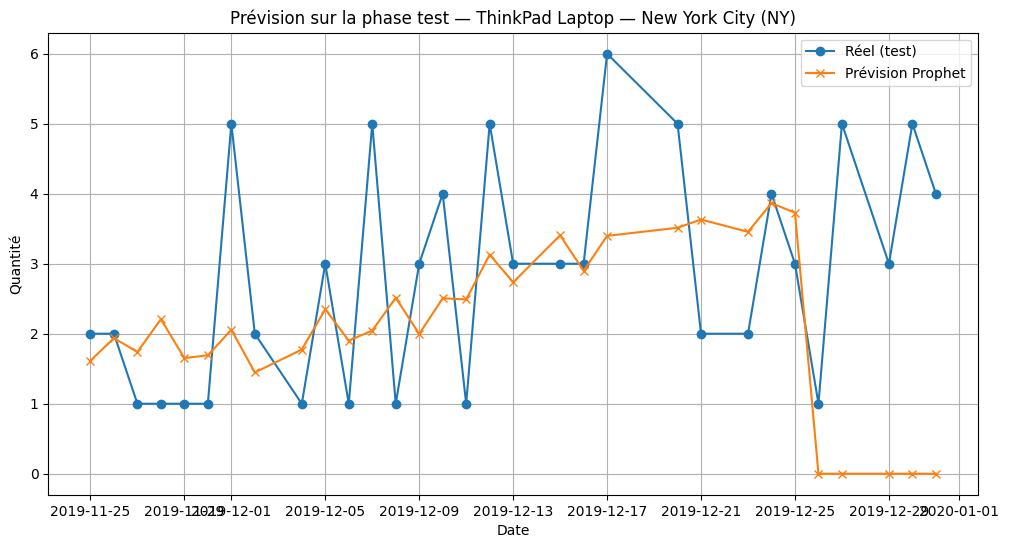

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Portland (OR) | MAE=1.29, RMSE=1.56


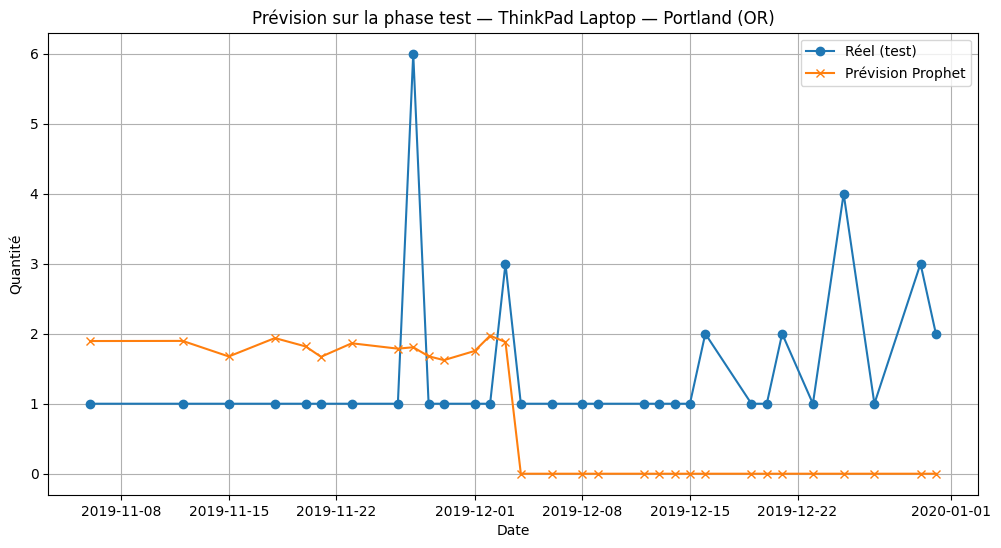

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — San Francisco (CA) | MAE=1.71, RMSE=2.30


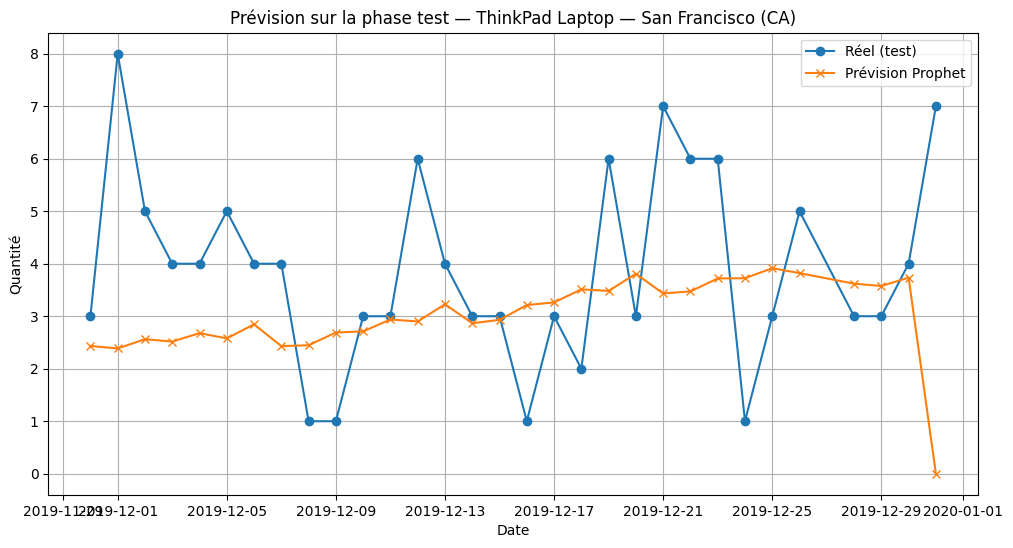

/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Seattle (WA) | MAE=1.29, RMSE=1.96


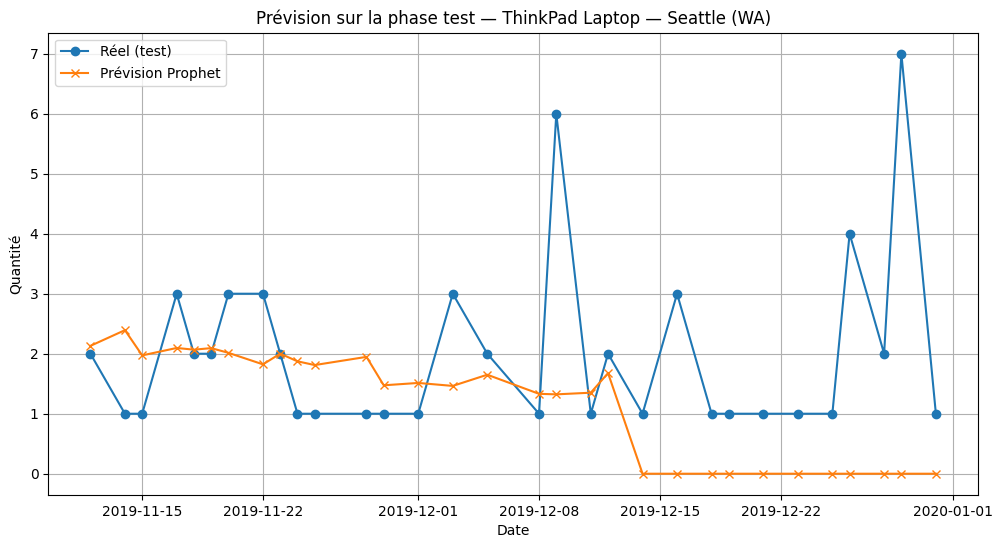

INFO:prophet:n_changepoints greater than number of observations. Using 13.
/tmp/ipython-input-404736809.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast['ds'].isin(test['ds'])]


Entraînement achevé : ThinkPad Laptop — Portland (ME) | MAE=0.97, RMSE=1.14


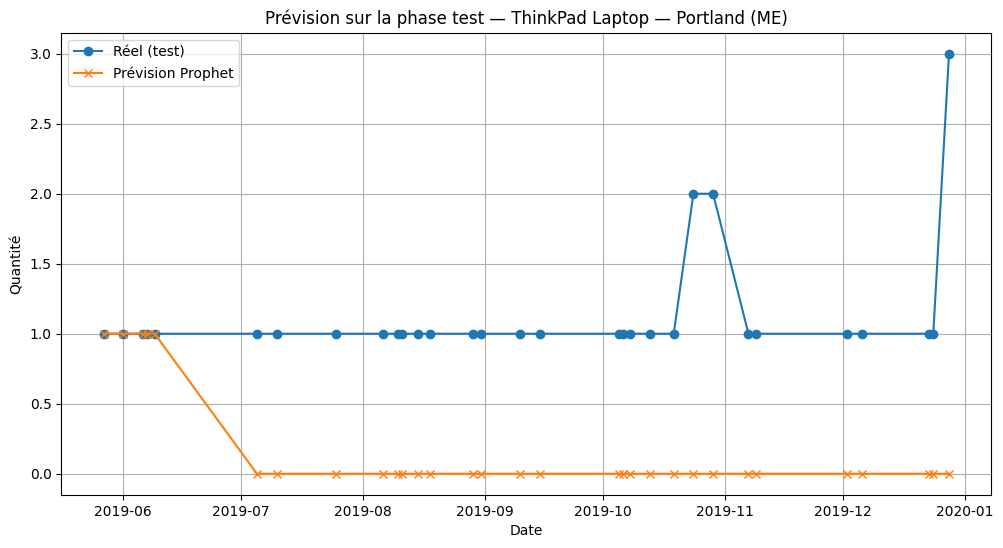

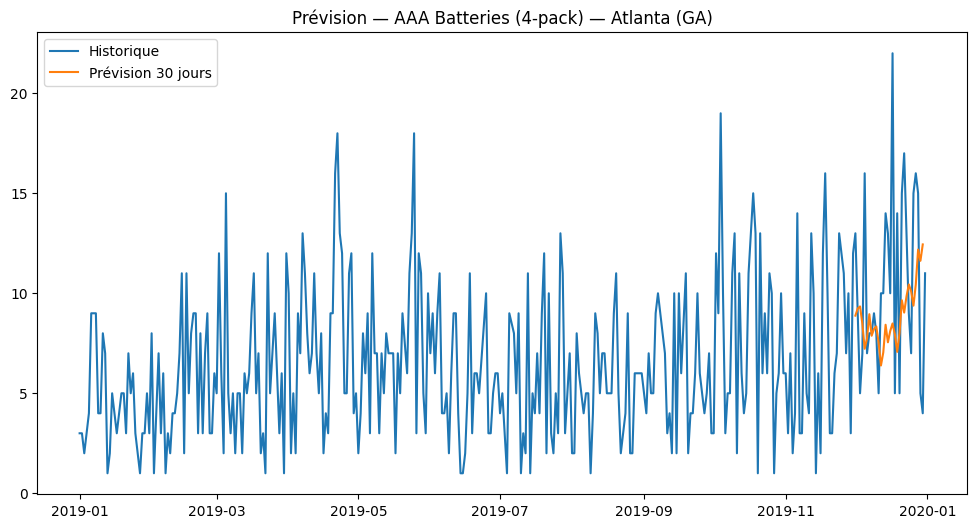

In [34]:
df = time_series_daily.copy()
df = df.rename(columns={"OnlyDate": "ds", "Quantity Ordered": "y"})

products = df["Product"].unique()
zones = df["Geographic Zone"].unique()

models = {}
model_metrics = {}

for product in products:
    for zone in zones:

        subset = df[(df["Product"] == product) & (df["Geographic Zone"] == zone)].copy()

        test_days = 30
        train = subset.iloc[:-31]
        test  = subset.iloc[-31:]

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        model.fit(train)

        future = model.make_future_dataframe(periods=len(test), freq="D")
        forecast = model.predict(future)
        forecast = forecast[forecast['ds'].isin(test['ds'])]

        y_pred = forecast.set_index("ds")["yhat"].reindex(test["ds"]).values

        y_pred = np.nan_to_num(y_pred, nan=0)

        if len(y_pred) == len(test["y"]):
          mae = mean_absolute_error(test["y"], y_pred)
          rmse = np.sqrt(mean_squared_error(test["y"], y_pred))
        else:
          mae = mean_absolute_error(test['y'][:len(y_pred)],y_pred)
          rmse = np.sqrt(mean_squared_error(test['y'][:len(y_pred)],y_pred))
        model_metrics[(product, zone)] = {"MAE": mae, "RMSE": rmse}
        models[(product, zone)] = model

        print(f"Entraînement achevé : {product} — {zone} | MAE={mae:.2f}, RMSE={rmse:.2f}")
        plt.figure(figsize=(12,6))

        plt.plot(test["ds"], test["y"], label="Réel (test)", marker="o")
        plt.plot(test["ds"], y_pred, label="Prévision Prophet", marker="x")

        plt.title(f"Prévision sur la phase test — {product} — {zone}")
        plt.xlabel("Date")
        plt.ylabel("Quantité")
        plt.legend()
        plt.grid(True)
        plt.show()

def forecast_product_zone(product, zone, days):
    key = (product, zone)

    model = models[key]

    future = model.make_future_dataframe(periods=days, freq='D')
    forecast = model.predict(future)

    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(days)


example_product = products[0]
example_zone = zones[0]

pred = forecast_product_zone(example_product, example_zone, 30)

plt.figure(figsize=(12,6))
plt.plot(df[(df["Product"] == example_product) &
            (df["Geographic Zone"] == example_zone)]["ds"],
         df[(df["Product"] == example_product) &
            (df["Geographic Zone"] == example_zone)]["y"], label="Historique")

plt.plot(pred["ds"], pred["yhat"], label="Prévision 30 jours")
plt.title(f"Prévision — {example_product} — {example_zone}")
plt.legend()
plt.show()



Bien qu'ayant un bon score plus proche de 0 que pour le cas de l'approche par mois, on remarque que certaine des valeurs générer sont nulles, et que le modèle est quand même éloigné de la courbe de celui attendu

## Modèle lightgbm

In [35]:
df = time_series_daily.copy()
df['OnlyDate'] = pd.to_datetime(df['OnlyDate'])

df['Year'] = df['OnlyDate'].dt.year
df['Month'] = df['OnlyDate'].dt.month
df['Day'] = df['OnlyDate'].dt.day
df['DayOfWeek'] = df['OnlyDate'].dt.dayofweek
df = df.sort_values("OnlyDate")

df["Lag1"] = df.groupby(["Geographic Zone", "Product"])["Quantity Ordered"].shift(1)
df["Lag7"] = df.groupby(["Geographic Zone", "Product"])["Quantity Ordered"].shift(7)

df.to_csv("Daily time series.csv")
le_zone = LabelEncoder()
le_prod = LabelEncoder()

df['Geographic Zone'] = le_zone.fit_transform(df['Geographic Zone'])
df['Product'] = le_prod.fit_transform(df['Product'])

df = df.dropna()

split_date = df['OnlyDate'].quantile(0.8)
train = df[df['OnlyDate'] <= split_date]
test  = df[df['OnlyDate'] >  split_date]

df["Geographic Zone"] = le_zone.inverse_transform(df["Geographic Zone"])
df["Product"] = le_prod.inverse_transform(df["Product"])
features = [
    'Year', 'Month', 'Day', 'DayOfWeek',
    'Geographic Zone', 'Product',
    'Lag1', 'Lag7'
]

X_train = train[features]
y_train = train['Quantity Ordered']

X_test  = test[features]
y_test  = test['Quantity Ordered']

tscv = TimeSeriesSplit(n_splits=4)

param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 0.9],
    "max_depth": [2, 6, 10]
}

model = LGBMRegressor()

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

print("Grid search en cours...")
grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres :")
print(grid.best_params_)

best_model = grid.best_estimator_
preds = best_model.predict(X_test)
preds = np.nan_to_num(preds, nan=0)

Grid search en cours...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 4357, number of used features: 7
[LightGBM] [Info] Start training from score 5.932981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with


=== Seattle (WA) — AAA Batteries (4-pack) ===
MAE  : 4.0988
RMSE : 5.3627


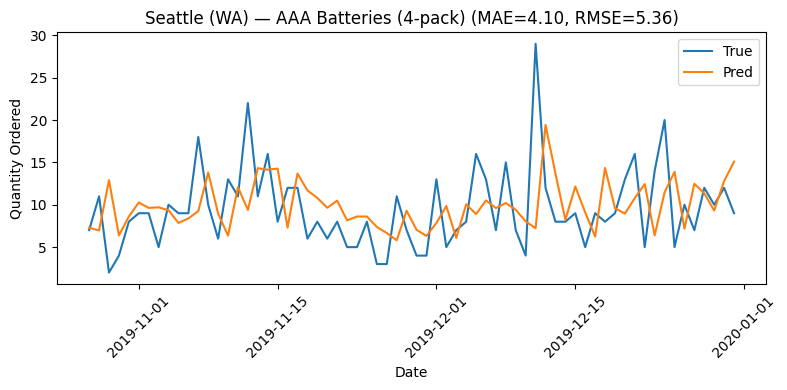


=== Seattle (WA) — ThinkPad Laptop ===
MAE  : 1.0216
RMSE : 1.6212


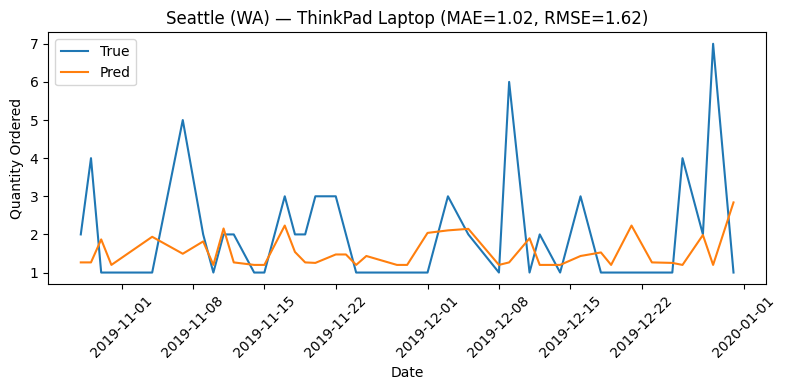


=== San Francisco (CA) — AAA Batteries (4-pack) ===
MAE  : 8.6774
RMSE : 11.9406


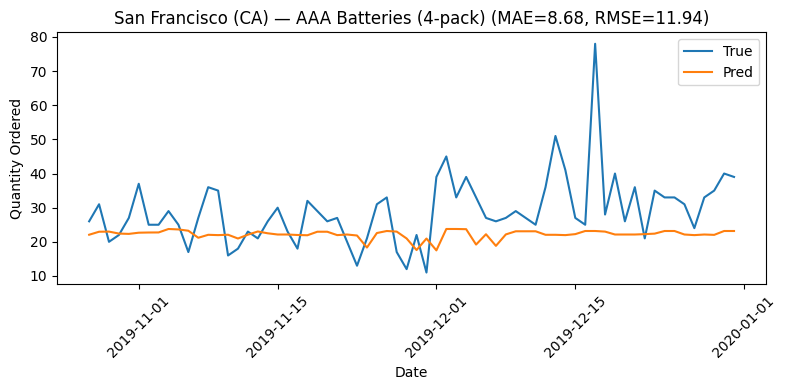


=== San Francisco (CA) — ThinkPad Laptop ===
MAE  : 1.2778
RMSE : 1.7184


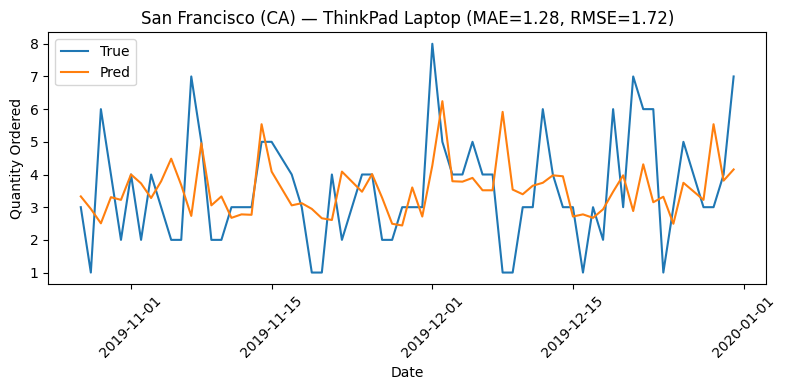


=== Portland (OR) — AAA Batteries (4-pack) ===
MAE  : 3.4286
RMSE : 4.5213


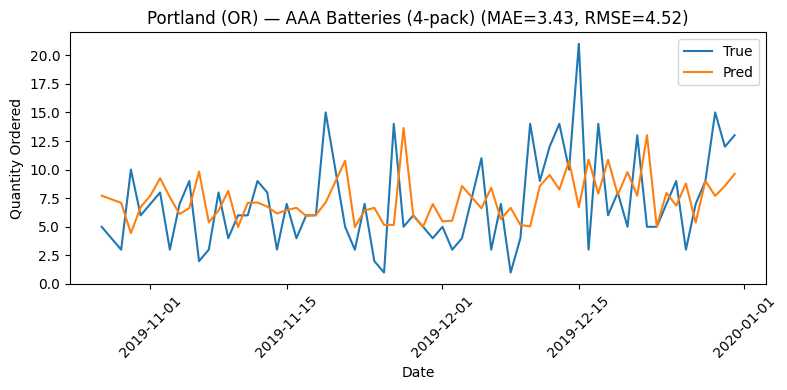


=== Portland (OR) — ThinkPad Laptop ===
MAE  : 0.7291
RMSE : 1.2529


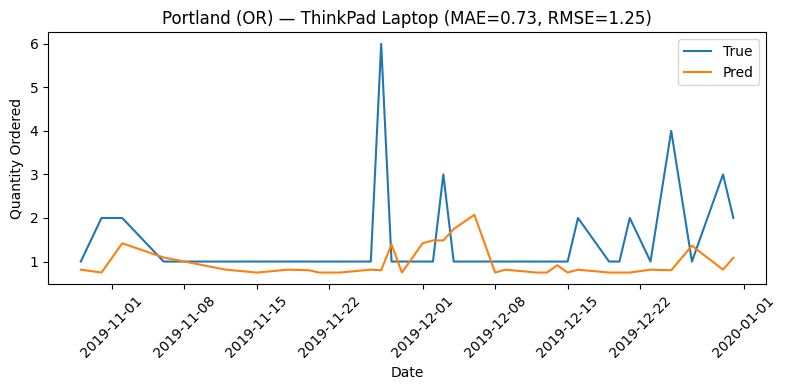


=== Portland (ME) — AAA Batteries (4-pack) ===
MAE  : 2.4527
RMSE : 2.7373


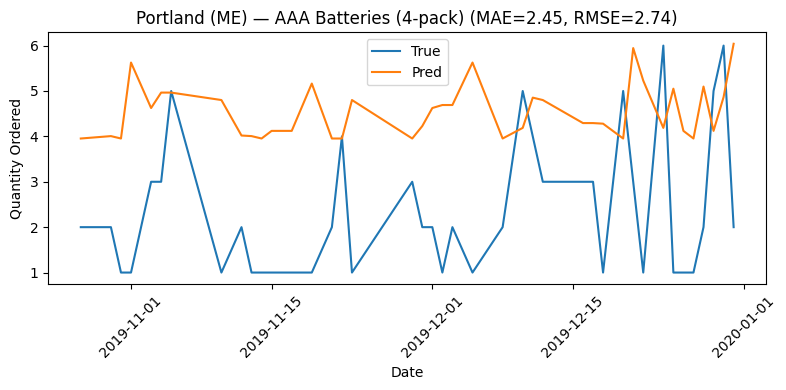


=== Portland (ME) — ThinkPad Laptop ===
MAE  : 0.5789
RMSE : 0.9256


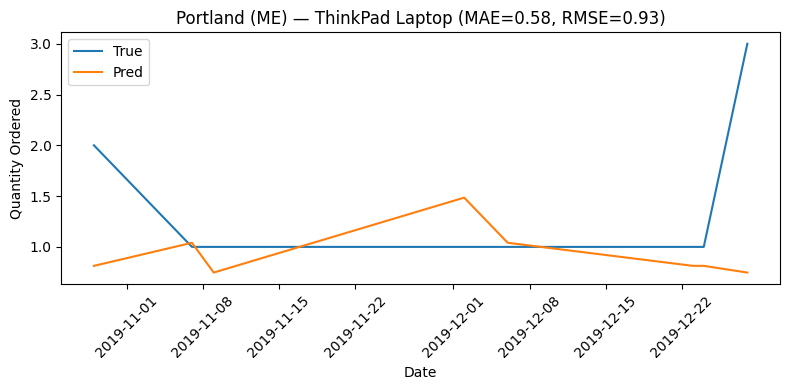


=== New York City (NY) — AAA Batteries (4-pack) ===
MAE  : 5.4068
RMSE : 6.7718


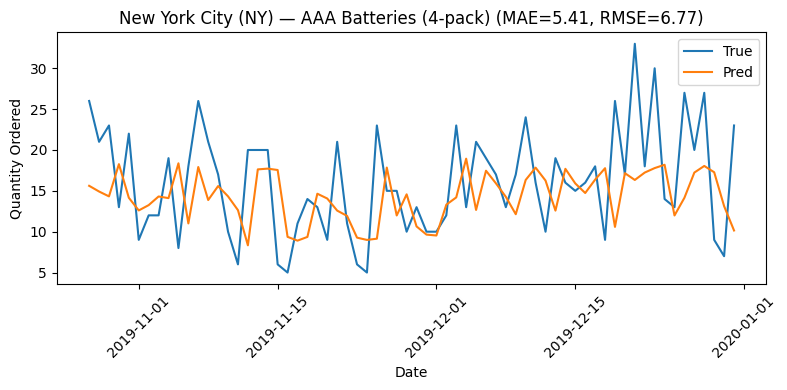


=== New York City (NY) — ThinkPad Laptop ===
MAE  : 1.3943
RMSE : 1.7873


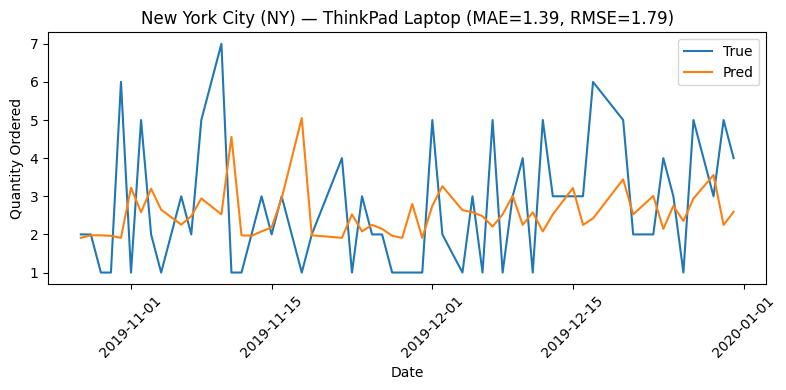


=== Los Angeles (CA) — AAA Batteries (4-pack) ===
MAE  : 5.6344
RMSE : 7.1342


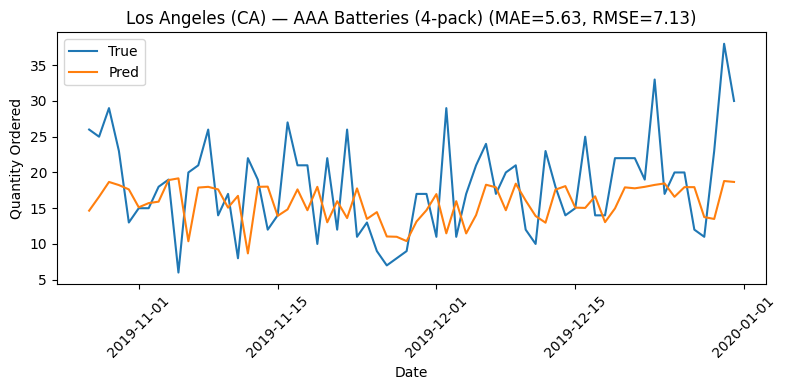


=== Los Angeles (CA) — ThinkPad Laptop ===
MAE  : 1.0628
RMSE : 1.2531


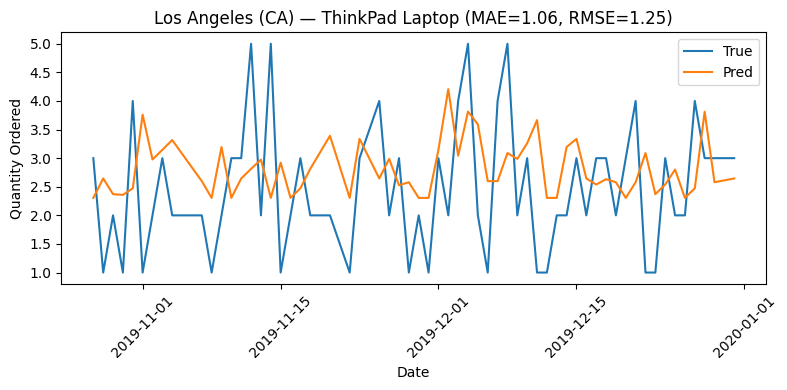


=== Dallas (TX) — AAA Batteries (4-pack) ===
MAE  : 4.4899
RMSE : 5.8265


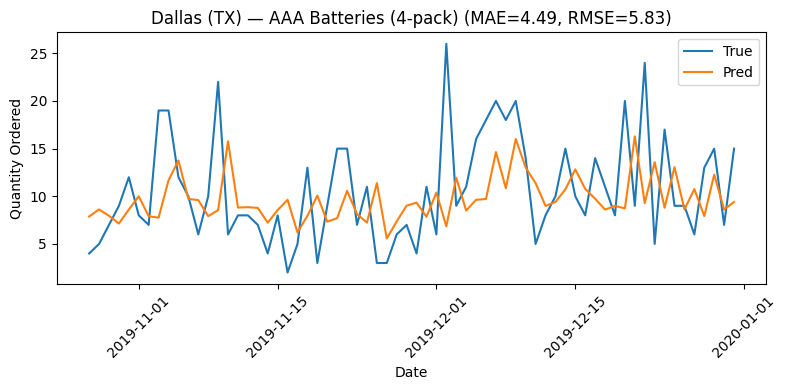


=== Dallas (TX) — ThinkPad Laptop ===
MAE  : 0.8077
RMSE : 0.9797


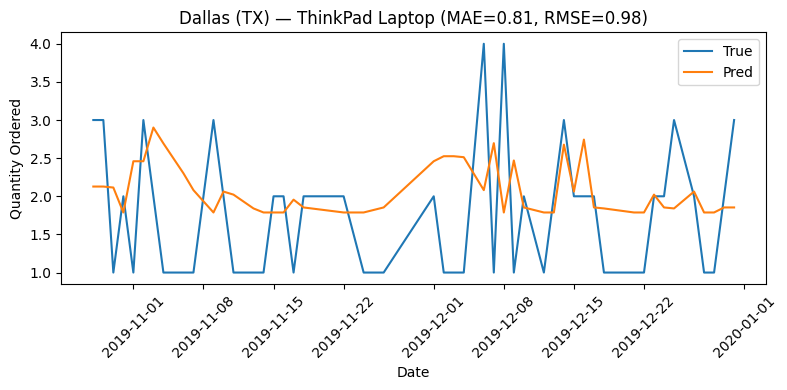


=== Boston (MA) — AAA Batteries (4-pack) ===
MAE  : 4.5702
RMSE : 5.6046


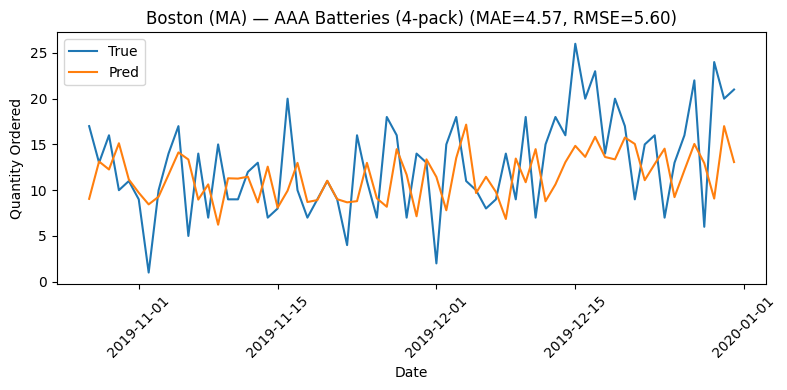


=== Boston (MA) — ThinkPad Laptop ===
MAE  : 1.0808
RMSE : 1.3310


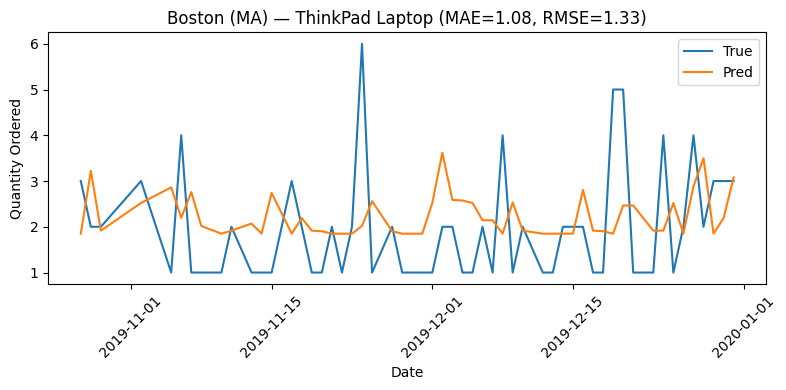


=== Austin (TX) — AAA Batteries (4-pack) ===
MAE  : 2.9682
RMSE : 3.9993


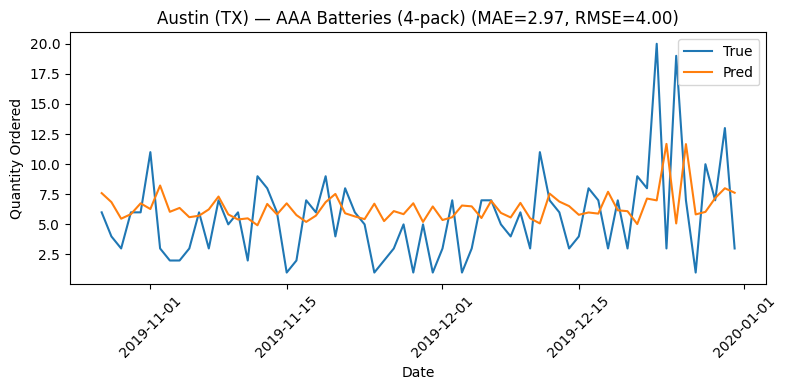


=== Austin (TX) — ThinkPad Laptop ===
MAE  : 0.7238
RMSE : 0.8711


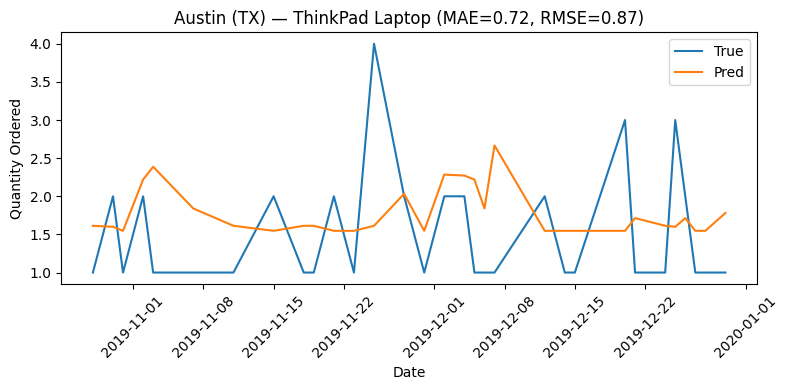


=== Atlanta (GA) — AAA Batteries (4-pack) ===
MAE  : 3.5322
RMSE : 4.4367


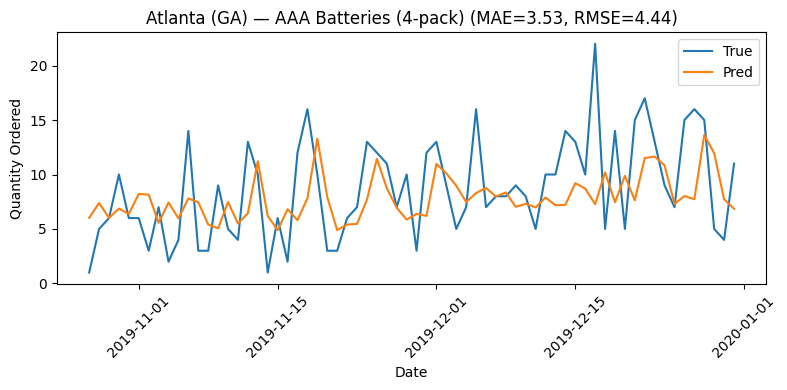


=== Atlanta (GA) — ThinkPad Laptop ===
MAE  : 0.8543
RMSE : 1.0072


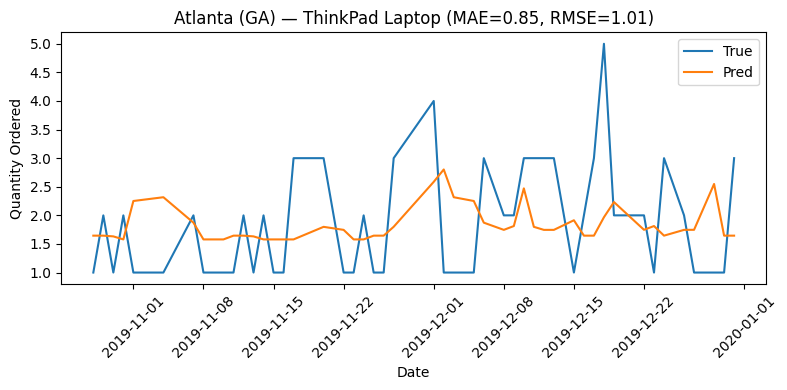

In [36]:
plot_df = test.copy()
plot_df["Pred"] = preds

plot_df["Geographic Zone"] = le_zone.inverse_transform(plot_df["Geographic Zone"])
plot_df["Product"] = le_prod.inverse_transform(plot_df["Product"])
zones = plot_df["Geographic Zone"].unique()
products = plot_df["Product"].unique()

for zone in zones:
    for product in products:

        data = plot_df[
            (plot_df["Geographic Zone"] == zone) &
            (plot_df["Product"] == product)
        ]

        if len(data) == 0:
            continue

        mae = mean_absolute_error(data["Quantity Ordered"], data["Pred"])
        rmse = np.sqrt(mean_squared_error(data["Quantity Ordered"], data["Pred"]))

        print(f"\n=== {zone} — {product} ===")
        print(f"MAE  : {mae:.4f}")
        print(f"RMSE : {rmse:.4f}")

        plt.figure(figsize=(8, 4))
        plt.plot(data["OnlyDate"], data["Quantity Ordered"], label="True")
        plt.plot(data["OnlyDate"], data["Pred"], label="Pred")

        plt.title(f"{zone} — {product} (MAE={mae:.2f}, RMSE={rmse:.2f})")
        plt.xlabel("Date")
        plt.ylabel("Quantity Ordered")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

Sauvegardons le modèle obtenue

In [37]:
joblib.dump(best_model, "lgb_best_model.pkl")
joblib.dump(le_prod, "product_encoder.pkl")
joblib.dump(le_prod, "zone_encoder.pkl")

['zone_encoder.pkl']

Enfin, créons une fonction qui permettra de générer des futures tendances à partir de notre modèle

In [39]:
def predict_future(model, product_encoder, zone_encoder, dataframe, days_ahead=7):
    """
    Prévoit les n prochains jours pour chaque produit × zone,
    en utilisant un modèle global avec lags Lag1, Lag2.

    df doit contenir :
    - OnlyDate
    - Geographic Zone
    - Product
    - Quantity Ordered
    - Lag1
    - Lag2
    - autres features déjà calculées
    """
    features = [
    'Year', 'Month', 'Day', 'DayOfWeek',
    'Geographic Zone', 'Product',
    'Lag1', 'Lag7'
    ]

    dataframe = dataframe.sort_values("OnlyDate")

    zones = dataframe["Geographic Zone"].unique()
    products = dataframe["Product"].unique()

    future_rows = []
    last_points = (
        df.groupby(["Geographic Zone", "Product"])
        .tail(1)
        .reset_index(drop=True)
    )

    working_data = last_points.copy()

    for step in range(days_ahead):
        working_data["OnlyDate"] = working_data["OnlyDate"] + pd.Timedelta(days=1)

        working_data["Year"] = working_data["OnlyDate"].dt.year
        working_data["Month"] = working_data["OnlyDate"].dt.month
        working_data["Day"] = working_data["OnlyDate"].dt.day
        working_data["DayOfWeek"] = working_data["OnlyDate"].dt.dayofweek

        working_data["Lag1"] = working_data["Quantity Ordered"]
        working_data["Lag2"] = working_data["Lag1"]
        working_data["Product"] = product_encoder.transform(working_data["Product"])
        working_data["Geographic Zone"] = zone_encoder.transform(working_data["Geographic Zone"])

        pred = model.predict(working_data[features])
        pred = np.maximum(pred, 0)
        working_data["Quantity Ordered"] = pred.astype(int)
        working_data["Geographic Zone"] = zone_encoder.inverse_transform(working_data["Geographic Zone"])
        working_data["Product"] = product_encoder.inverse_transform(working_data["Product"])
        future_rows.append(
            working_data[
                ["OnlyDate", "Product", "Geographic Zone", "Quantity Ordered"]
            ].copy()
        )

    future_df = pd.concat(future_rows, ignore_index=True)

    return future_df

future_forecast = predict_future(best_model, le_prod, le_zone, df.groupby(['Product','Geographic Zone']).tail(1), days_ahead=31)
print(future_forecast)

      OnlyDate                 Product     Geographic Zone  Quantity Ordered
0   2019-12-29         ThinkPad Laptop       Portland (ME)                 1
1   2019-12-31         ThinkPad Laptop         Austin (TX)                 1
2   2020-01-01         ThinkPad Laptop  San Francisco (CA)                 4
3   2020-01-01  AAA Batteries (4-pack)  San Francisco (CA)                20
4   2020-01-01         ThinkPad Laptop       Portland (OR)                 0
..         ...                     ...                 ...               ...
615 2020-01-31         ThinkPad Laptop        Atlanta (GA)                 1
616 2020-01-31  AAA Batteries (4-pack)        Atlanta (GA)                 5
617 2020-01-31  AAA Batteries (4-pack)        Seattle (WA)                14
618 2020-01-31  AAA Batteries (4-pack)    Los Angeles (CA)                12
619 2020-01-31         ThinkPad Laptop        Seattle (WA)                 0

[620 rows x 4 columns]


In [41]:
future_forecast.to_csv("January 2020 predictions.csv")

# Assistant LLM Interactif

On va mettre en place un léger pipeline RAG, afin de considerer comme contexte les prédictions de notre modèle précédent. Nous allons utiliser Ollama pour le modèle LLM et langchain pour le RAG


In [55]:
!curl -fsSL https://ollama.com/install.sh | sh
!nohup ollama serve > ollama.log 2>&1 &
!ollama pull qwen2.5:14b
!ollama pull mistral-small

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################### 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.




In [49]:
def df_to_texts_daily(df, product_encoder, zone_encoder):

    def row_to_text(row):
        months = ["Janvier","Fevrier","Mars","Avril","Mai","Juin","Juillet",
                  "Aout","Septembre","Octobre","Novembre","Decembre"]

        date = pd.to_datetime(row["OnlyDate"])
        day = date.day
        month_name = months[date.month - 1]
        year = date.year

        product_label = row["Product"]
        zone_label = row["Geographic Zone"]
        return (
            f"Date : {day} {month_name} {year} | "
            f"Produit : {product_label} | "
            f"Zone : {zone_label} | "
            f"Quantité prévue : {int(row['Quantity Ordered'])}"
        )
    datas = [row_to_text(r) for _, r in df.iterrows()]

    return datas


In [50]:
texts = df_to_texts_daily(future_forecast, product_encoder, zone_encoder)

In [51]:
texts

['Date : 29 Decembre 2019 | Produit : ThinkPad Laptop | Zone : Portland (ME) | Quantité prévue : 1',
 'Date : 31 Decembre 2019 | Produit : ThinkPad Laptop | Zone : Austin (TX) | Quantité prévue : 1',
 'Date : 1 Janvier 2020 | Produit : ThinkPad Laptop | Zone : San Francisco (CA) | Quantité prévue : 4',
 'Date : 1 Janvier 2020 | Produit : AAA Batteries (4-pack) | Zone : San Francisco (CA) | Quantité prévue : 20',
 'Date : 1 Janvier 2020 | Produit : ThinkPad Laptop | Zone : Portland (OR) | Quantité prévue : 0',
 'Date : 1 Janvier 2020 | Produit : AAA Batteries (4-pack) | Zone : Portland (OR) | Quantité prévue : 8',
 'Date : 1 Janvier 2020 | Produit : AAA Batteries (4-pack) | Zone : Portland (ME) | Quantité prévue : 4',
 'Date : 1 Janvier 2020 | Produit : ThinkPad Laptop | Zone : New York City (NY) | Quantité prévue : 2',
 'Date : 1 Janvier 2020 | Produit : AAA Batteries (4-pack) | Zone : New York City (NY) | Quantité prévue : 14',
 'Date : 1 Janvier 2020 | Produit : ThinkPad Laptop | Zon

In [53]:
embedding = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

''' db = Chroma.from_texts(
    texts,
    embedding,
    collection_name="demand_forecast",
    persist_directory=None
) '''

llm = Ollama(model="qwen2.5:14b")
#llm = Ollama(model="mistral-small")
#retriever = db.as_retriever(search_kwargs={"k": 6})

full_context = "\n".join(texts)

prompt = PromptTemplate(
    template="""
Tu es un expert en prévisions de la demande.
Tu dois répondre uniquement à partir du contexte fourni, qui représente des prédictions journalières.
Si l'information est insuffisante, dis-le clairement.

CONTEXT:
{context}

QUESTION:
{question}

La plupart des questions demanderont d'analyser les prédictions
Par exemple :
 - si l'on demande la zone géographique nécessitant une augmentation de stock → tu devras identifier la zone où la demande prévue est la plus élevée.
 - si l'on te demande une comparaison, analyse les quantités prévues sur les zones géographiques (ville) voir même les dates concernées.

Important :
 - Tu dois t'appuyer uniquement sur les prédictions fournies dans le CONTEXT.
 - N'invente jamais de chiffres ou de dates.
 - Commence TOUJOURS ta réponse en rappelant très brièvement les informations du contexte utiles à la question.

Réponse concise, structurée et utile :
""",
    input_variables=["context", "question"]
)

qa = LLMChain(
    llm=llm,
    prompt=PromptTemplate(
        template=prompt.template.replace("CONTEXT:\n{context}", f"CONTEXT:\n{full_context}"), # le retriever fait sauter la session Colab pour récuperer plus de 8 éléments, on va donc prendre en considération toutes les prédictions en contexte
        input_variables=["question"],
    )
)

In [ ]:
response = qa.run({"question":"Dans quelle zone géographique doit-on augmenter les stocks de ThinkPad Laptop?"})
print(response)

/tmp/ipython-input-2561127390.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa.run({"question":"Dans quelle zone géographique doit-on augmenter les stocks de ThinkPad Laptop?"})
